## MScA 32018: Natural Language Processing & Cognitive Computing

#### Final Project
#### 5/30/21

In this project, we will be working with a corpus of news articles from a one year time period. The articles are related to either the city of Chicago, the state of Illinois, or both.

The goal of this analysis is two-fold: first, we will use NLP techniques to identify some of the key factors influencing Illinois' declining population, and second we will provide actionable recommendations on how this trend can be reversed.

#### Load Baseline Packages

In [30]:
from google.colab import drive

import time
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 250)

import re

from pprint import pprint
import progressbar

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

import nltk as nltk
import nltk.corpus
from nltk.text import Text

In [6]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [45]:
# connect to Google Drive file directory
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls "/content/gdrive/My Drive/Colab Notebooks/NLP/data"

articles_clean.pkl	 ktrain_8topic_model.pkl  lda_tuning_results.pkl
articles_subset.pkl	 lda_model_5topic.pkl	  news_chicago_il.json
ktrain_5topic_model.pkl  lda_tuning_results.csv


In [7]:
directory = "/content/gdrive/My Drive/Colab Notebooks/NLP/data/"

In [ ]:
news_articles = "news_chicago_il.json"

path = directory + news_articles

#### Confirm GPU

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jun  2 02:28:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Load the data from JSON

In [ ]:
%time articles_full = pd.read_json(path, orient='records', lines=True)

CPU times: user 5.25 s, sys: 3.14 s, total: 8.39 s
Wall time: 8.57 s


In [ ]:
articles_full.shape

(405455, 4)

In [ ]:
# get some basic informatin on the dataset
articles_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405455 entries, 0 to 405454
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   crawled_date  405455 non-null  int64 
 1   language      405455 non-null  object
 2   text          405455 non-null  object
 3   title         405455 non-null  object
dtypes: int64(1), object(3)
memory usage: 12.4+ MB


In [ ]:
articles_full.head(5)

,crawled_date,language,text,title
0,1589155200000,english,\nGov. Jay “Fatso” Pritzker called on all Illi...,All In Illinois
1,1589155200000,english,"May 10, 2020 -The Illinois Department of Publi...",The Illinois Department of Public Health Annou...
2,1589155200000,english,"Gloria Lawrence said: May 10, 2020 at 1:31 AM\...","Foto Friday: Alton, Illinois"
3,1589155200000,english,NBA to follow German soccer league model with ...,Chris Broussard on Michael Jordan returning to...
4,1589155200000,english,"Search Minggu, 10 Mei 2020 Pork chops vs. peop...",Pork chops vs. people: Can Americans’ appetite...


No surprises here. Only four columns: when the article was retrived, what language it's in, the text, and the title. We don't have any null values in our dataset.

The one thing to note is that the 'crawled_date' column appears to be in integer format. Might be helpful to convert it to date. 

In [ ]:
# convert columns indicated when article was crawled to datatime format
%time articles_full['crawled_date'] = pd.to_datetime(articles_full['crawled_date'], infer_datetime_format=True, unit='ns')

CPU times: user 9.08 ms, sys: 2.02 ms, total: 11.1 ms
Wall time: 10.5 ms


In [ ]:
type(articles_full)

pandas.core.frame.DataFrame

In [ ]:
articles_full.head()

,crawled_date,language,text,title
0,1970-01-01 00:26:29.155200,english,\nGov. Jay “Fatso” Pritzker called on all Illi...,All In Illinois
1,1970-01-01 00:26:29.155200,english,"May 10, 2020 -The Illinois Department of Publi...",The Illinois Department of Public Health Annou...
2,1970-01-01 00:26:29.155200,english,"Gloria Lawrence said: May 10, 2020 at 1:31 AM\...","Foto Friday: Alton, Illinois"
3,1970-01-01 00:26:29.155200,english,NBA to follow German soccer league model with ...,Chris Broussard on Michael Jordan returning to...
4,1970-01-01 00:26:29.155200,english,"Search Minggu, 10 Mei 2020 Pork chops vs. peop...",Pork chops vs. people: Can Americans’ appetite...


Weird, articles still show strange dates. Forget about it, we're focused on the titles and article text, really.

In [ ]:
# check if there are any non-English articles
articles_full['language'].unique()

array(['english'], dtype=object)

### Filter For Relevant Articles Using RAKE Keywords

In [ ]:
# remove duplicates in 
articles_deduped = articles_full.drop_duplicates(subset=['title'], keep='first')
articles_deduped = articles_deduped.drop_duplicates(subset='text', keep='first')

articles_deduped.shape

(270365, 4)

In [ ]:
! pip install rake_nltk

  Created wheel for rake-nltk: filename=rake_nltk-1.0.4-py2.py3-none-any.whl size=7819 sha256=e1902d35c67eff3d5cb35cb888527c4b528f374f2a4a8d2f3dc9e942ae08488c
  Stored in directory: /root/.cache/pip/wheels/ef/92/fc/271b3709e71a96ffe934b27818946b795ac6b9b8ff8682483f
Successfully built rake-nltk


In [ ]:
from rake_nltk import Rake

In [ ]:
# Remove /n characters to avoid problems with analysis
# Remove special characters to avoid problems with analysis

articles_deduped['text_clean'] = articles_deduped['text'].map(lambda x: re.sub(r'\n', '.  ', str(x)))
articles_deduped['text_clean'] = articles_deduped['text_clean'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', '', str(x)))

In [ ]:
pd.set_option('display.max_colwidth', 200)
articles_deduped.head(5)

,crawled_date,language,text,title,text_clean,rake_text_phrases,rake_title_phrases
0,1970-01-01 00:26:29.155200,english,. Gov. Jay “Fatso” Pritzker called on all Illinois residents to be “All in for Illinois” and to sequester at home.. “Now the rest is up to you. Our strongest weapon against COVID-19 is you. For ...,All In Illinois,. Gov. Jay Fatso Pritzker called on all Illinois residents to be All in for Illinois and to sequester at home.. Now the rest is up to you. Our strongest weapon against COVID19 is you. For a litt...,"“ lavish ” fl equestrian estate .. “ apparently, “ hyatt hotel fortune ” probably deals, limits ,” carlson added .. pritzker refused, gm0amao5cs — steve cortes (@ cortessteve, illinois rising acti...",illinois
1,1970-01-01 00:26:29.155200,english,"May 10, 2020 -The Illinois Department of Public Health (IDPH) today announced 1,656 new cases of coronavirus disease (COVID-19) in Illinois, including 57 additional deaths. Cook County: 2 males 20...","The Illinois Department of Public Health Announces 1,656 New Cases; 57 Additional Deaths","May 10, 2020 The Illinois Department of Public Health IDPH today announced 1,656 new cases of coronavirus disease COVID19 in Illinois, including 57 additional deaths. Cook County: 2 males 20s, 2 m...","1 male 30s kankakee county, 1 male 90s winnebago county, 1 male 60s peoria county, 1 female 80s st, including 57 additional deaths, 1 male 100, 1 unknown 90s, 1 unknown 60s, 1 female 50s, today an...","public health announces 1, 656 new cases, 57 additional deaths, illinois department"
2,1970-01-01 00:26:29.155200,english,"Gloria Lawrence said: May 10, 2020 at 1:31 AM. The backwater area is close to dry right now. Army Corps of Engineers raises and lowers water levels by using the locks in the dam. They do their be...","Foto Friday: Alton, Illinois","Gloria Lawrence said: May 10, 2020 at 1:31 AM. The backwater area is close to dry right now. Army Corps of Engineers raises and lowers water levels by using the locks in the dam. They do their be...","mother nature often wins, wish us luck, gloria lawrence said, lowers water levels, two friends, snow melt, prevent floods, minor flooding, may 10, live near, illinois river, heavy rains, engineers...","foto friday, illinois, alton"
3,1970-01-01 00:26:29.155200,english,"NBA to follow German soccer league model with return-to-play plan? May 11, 2020 You must be 18 years old or older to gamble in most jurisdictions. IN some jurisdictions it is against the law to ga...",Chris Broussard on Michael Jordan returning to the Chicago Bulls in the 94-95 season,"NBA to follow German soccer league model with returntoplay plan May 11, 2020 You must be 18 years old or older to gamble in most jurisdictions. IN some jurisdictions it is against the law to gambl...","free 3 day two night vacation voucher, follow german soccer league model, accept terms sexy gambling 247, advanced online casino gaming products, world class online casino, sexy gambling 247, over...","michael jordan returning, chris broussard, chicago bulls, 95 season, 94"
4,1970-01-01 00:26:29.155200,english,"Search Minggu, 10 Mei 2020 Pork chops vs. people: Can Americans’ appetite for meat be filled without risking workers’ safety? - Chicago Tribune. Thompson and other local officials lobbied Tyson t...",Pork chops vs. people: Can Americans’ appetite for meat be filled without risking workers’ safety? - Chicago Tribune,"Search Minggu, 10 Mei 2020 Pork chops vs. people: Can Americans appetite for meat be filled without risking workers safety Chicago Tribune. Thompson and other local officials lobbied Tyson to cl...","10 mei 2020 pork chops vs, filled without risking workers ’ safety, county health officials asked tyson, april 14 phone call, local officials lobbied tyson, americans ’ appetite, cooperative ,” sa...","filled without risking workers ’ safety, americans ’ appetite, pork chops vs, chicago tribune, people, meat"


In [ ]:
r = Rake() # Uses stopwords for english from NLTK, and all puntuation characters.

def get_keywords(x,r):
    
    # r.extract_keywords_from_text(<text to process>)
    r.extract_keywords_from_text(x)
    
    # r.get_ranked_phrases() # To get keyword phrases ranked highest to lowest.
    return r.get_ranked_phrases() 

In [ ]:
%time articles_deduped['rake_text_phrases'] = articles_deduped['text_clean'].apply(lambda x: get_keywords(x,r)).apply(', '.join)

CPU times: user 7min 8s, sys: 1.41 s, total: 7min 10s
Wall time: 7min 9s


In [ ]:
%time articles_deduped['rake_title_phrases'] = articles_deduped['title'].apply(lambda x: get_keywords(x,r)).apply(', '.join)

CPU times: user 24.9 s, sys: 51.9 ms, total: 25 s
Wall time: 24.9 s


In [ ]:
articles_deduped[['title', 'rake_title_phrases', 'text_clean', 'rake_text_phrases']].head(5)

,title,rake_title_phrases,text,rake_text_phrases
0,All In Illinois,illinois,. Gov. Jay “Fatso” Pritzker called on all Illinois residents to be “All in for Illinois” and to sequester at home.. “Now the rest is up to you. Our strongest weapon against COVID-19 is you. For ...,"“ lavish ” fl equestrian estate .. “ apparently, “ hyatt hotel fortune ” probably deals, limits ,” carlson added .. pritzker refused, gm0amao5cs — steve cortes (@ cortessteve, illinois rising acti..."
1,"The Illinois Department of Public Health Announces 1,656 New Cases; 57 Additional Deaths","public health announces 1, 656 new cases, 57 additional deaths, illinois department","May 10, 2020 -The Illinois Department of Public Health (IDPH) today announced 1,656 new cases of coronavirus disease (COVID-19) in Illinois, including 57 additional deaths. Cook County: 2 males 20...","1 male 30s kankakee county, 1 male 90s winnebago county, 1 male 60s peoria county, 1 female 80s st, including 57 additional deaths, 1 male 100, 1 unknown 90s, 1 unknown 60s, 1 female 50s, today an..."
2,"Foto Friday: Alton, Illinois","foto friday, illinois, alton","Gloria Lawrence said: May 10, 2020 at 1:31 AM. The backwater area is close to dry right now. Army Corps of Engineers raises and lowers water levels by using the locks in the dam. They do their be...","mother nature often wins, wish us luck, gloria lawrence said, lowers water levels, two friends, snow melt, prevent floods, minor flooding, may 10, live near, illinois river, heavy rains, engineers..."
3,Chris Broussard on Michael Jordan returning to the Chicago Bulls in the 94-95 season,"michael jordan returning, chris broussard, chicago bulls, 95 season, 94","NBA to follow German soccer league model with return-to-play plan? May 11, 2020 You must be 18 years old or older to gamble in most jurisdictions. IN some jurisdictions it is against the law to ga...","free 3 day two night vacation voucher, follow german soccer league model, accept terms sexy gambling 247, advanced online casino gaming products, world class online casino, sexy gambling 247, over..."
4,Pork chops vs. people: Can Americans’ appetite for meat be filled without risking workers’ safety? - Chicago Tribune,"filled without risking workers ’ safety, americans ’ appetite, pork chops vs, chicago tribune, people, meat","Search Minggu, 10 Mei 2020 Pork chops vs. people: Can Americans’ appetite for meat be filled without risking workers’ safety? - Chicago Tribune. Thompson and other local officials lobbied Tyson t...","10 mei 2020 pork chops vs, filled without risking workers ’ safety, county health officials asked tyson, april 14 phone call, local officials lobbied tyson, americans ’ appetite, cooperative ,” sa..."


In [ ]:
print(articles_deduped[['text', 'rake_text_phrases']][articles_deduped['rake_text_phrases'].str.contains("population", na=False)].shape)
articles_deduped[['text', 'rake_text_phrases']][articles_deduped['rake_text_phrases'].str.contains("population", na=False)].head()

(7453, 2)


,text,rake_text_phrases
61,"Mayor Lightfoot announces plans for reopening Chicago By Reel Chicago May 11, 2020 0 Mayor Lori E. Lightfoot , alongside the Chicago Department of Public Health (CDPH), announced the “Protecting C...","influenzalike illness andor covidlike illness case investigation contact tracing, based onincidence andor percent positivity severe outcome rate, developed around three key areas including healthy..."
94,"New Adult-Use Customers Can Only Shop Online or Over-the-Phone for In-Store Pickup Medical Patients Can Shop In-Store, Online or Over-the-Phone for Convenient Curbside or In-Store Pickup BOCA RATO...","instore pickup frequently sanitizing hightouch surfaces deep cleaning, united states private securities litigation reform act, companys filing statement dated december 5, press release contains ce..."
111,"Pope Francis Names Father Louis Tylka of Archdiocese of Chicago as Coadjutor Bishop of Peoria May 11, 2020. WASHINGTON—Pope Francis has named Father Louis Tylka, a priest of the Archdiocese of Ch...","divinity 1996 .. father tylkas assignments, pope francis names father louis tylka, father tylka attended mundelein seminary, orland park 19962003 associate pastor, attended niles college seminary,..."
138,"As the coronavirus spreads, the Tribune is tracking Illinois cases here ». Here’s what’s happening Monday with COVID-19 in the Chicago area and Illinois: 5:46 p.m.: Church leaders push back on Li...","schedules .. city business affairs commissioner rosa escareno said deferring, next .. illinois municipal league executive director brad cole wrote, continue holding religious services despite anti..."
155,"Flipboard The latest Dr. Ngozi Ezike, director of the Illinois Department of Public Health, at a press conference in April. Tyler LaRiviere/Sun-Times (file photo) Another 54 people have died of CO...","used safety protocols like daily temperature checks, tyler larivieresuntimes file photo another 54 people, avoiding mass arrests mayor lori lightfoot said monday, signed mayor lightfoots chicago h..."


In [ ]:
articles_deduped[['title', 'rake_title_phrases', 'text', 'rake_text_phrases']][(articles_deduped['rake_text_phrases'].str.contains("population", na=False)) | (articles_deduped['rake_title_phrases'].str.contains("population", na=False))].shape

(7503, 4)

In [ ]:
criteria = (articles_deduped['rake_text_phrases'].str.contains("economy", na=False) | \
            articles_deduped['rake_title_phrases'].str.contains("economy", na=False) | \
            articles_deduped['rake_text_phrases'].str.contains("economic growth", na=False) | \
            articles_deduped['rake_text_phrases'].str.contains("economic growth", na=False))

articles_deduped[criteria][['title', 'rake_title_phrases', 'text', 'rake_text_phrases']]

,title,rake_title_phrases,text,rake_text_phrases
16,Pritzker: Illinois is ‘Going it Alone’ in Efforts to Increase COVID-19 Testing,"‘ going, increase covid, alone ’, 19 testing, pritzker, illinois, efforts","Another 1,656 people in Illinois have tested positive for the coronavirus, health officials announced Sunday, bringing the state’s total number of cases to 77,741.. The total number of fatalities...","vigorous contract tracing program .. illinois ’ new acting chief epidemiologist, additional 57 deaths reported sunday .., “ restore illinois ” plan .., officials advise taking preventive measures,..."
46,"Airfare Deal: Chicago - Sofia, Bulgaria. $453 (Basic Economy) / $583 (Regular Economy). Roundtrip, including all Taxes","regular economy )., basic economy, airfare deal, taxes, sofia, roundtrip, including, chicago, bulgaria, 583, 453",chicago sofia bulgaria,chicago sofia bulgaria
61,Mayor Lightfoot announces plans for reopening Chicago,"mayor lightfoot announces plans, reopening chicago","Mayor Lightfoot announces plans for reopening Chicago By Reel Chicago May 11, 2020 0 Mayor Lori E. Lightfoot , alongside the Chicago Department of Public Health (CDPH), announced the “Protecting C...","developed around three key areas including healthy interactions, illinois ’ “ restore illinois ” plan –, chicago residents per month testing percent positivity rates, “ protecting chicago ” framew..."
100,"BOOK: Matthew H. EDNEY & Mary SPONBERG PEDLEY (eds.), The History of Cartography, Volume 4. Cartography in the Enlightenment (Chicago: University of Chicago Press, May 2020), 1920 p., ISBN 9780226...","may 2020 ), 1920 p ., isbn 9780226184753, mary sponberg pedley, ),, volume 4, matthew h, 500 usd, chicago press, chicago, university, history, enlightenment, eds, edney, cartography, book","(image source: University of Chicago Press ). Book description: Since its launch in 1987, the History of Cartography series has garnered critical acclaim and sparked a new generation of interdisc...","swept enlightenment europe also transformed many, four hundred encyclopedic articles explore, scale cartographic projects became possible, yet older mapping practices persisted, nearly one thousan..."
102,Ford Targets May 18 to Reopen Chicago-Area Plants,"ford targets may 18, reopen chicago, area plants","Chicago-area auto assembly plants will reopen beginning on May 18, as part of a series of reopenings and gradual ramping-up of production by the Big Three U.S. automakers, the Chicago Tribune repo...","restart .. factories must adopt anti, two shifts .. fiat chrysler ’, tribune reported .. michigan gov, including daily entry screening, gretchen whitmer said thursday, area auto assembly plants, t..."
...,...,...,...,...
405192,Illinois’-Own COVID-19 Data Reveals State’s COVID-19 Policy Is Upside-Down,"19 data reveals state ’, 19 policy, illinois ’-, upside, covid","Authored by Ted Dabrowski and John Klingner via Wirepoints.org,. A Wirepoints review of last month’s COVID-19 data reveals just how flawed Illinois’ response to the coronavirus continues to be. T...","illinois ’ overall icu bed capacity )., illinois ’ hospital bed capacity grew, illinois ’ overall bed capacity, illinois ’ blanket lockdown policies, daily average often reached 80, younger illino..."
405220,Biden wins Illinois; Trump scores wins in South,"trump scores wins, biden wins illinois, south",WASHINGTON (AP) — Polls closed across the East Coast on Tuesday night as President Donald Trump and Democrat Joe Biden concluded an epic campaign marked by rancor and fear that will influence how ...,"139 million ballots cast four years ago .., eisenhower executive office building .. biden spent, 2016 presidential election .. biden entered election day, joining 102 million fellow americans, ass..."
405245,Illinois Senate numbers,illinois senate numbers,"Nov 3, 2020 / 07:38 PM CST / Updated: Nov 3, 2020 / 08:21 PM CST. (Updated 8 p.m.) ILLINOIS (AP) — AP is reporting incumbent Dick Durbin has won another

In [ ]:
criteria = (articles_deduped['rake_text_phrases'].str.contains("population", na=False) | \
            articles_deduped['rake_title_phrases'].str.contains("population", na=False) | \
            articles_deduped['rake_text_phrases'].str.contains("exodus", na=False) | \
            articles_deduped['rake_title_phrases'].str.contains("exodus", na=False) | \
            articles_deduped['rake_text_phrases'].str.contains("business", na=False) | \
            articles_deduped['rake_title_phrases'].str.contains("business", na=False) | \
            articles_deduped['rake_text_phrases'].str.contains("unemployment", na=False) | \
            articles_deduped['rake_title_phrases'].str.contains("unemployment", na=False) | \
            articles_deduped['rake_text_phrases'].str.contains("economy", na=False) | \
            articles_deduped['rake_title_phrases'].str.contains("economy", na=False) | \
            articles_deduped['rake_text_phrases'].str.contains("economic growth", na=False) | \
            articles_deduped['rake_title_phrases'].str.contains("economic growth", na=False) | \
            articles_deduped['rake_text_phrases'].str.contains("education", na=False) | \
            articles_deduped['rake_title_phrases'].str.contains("education", na=False) | \
            articles_deduped['rake_text_phrases'].str.contains("crime", na=False) | \
            articles_deduped['rake_title_phrases'].str.contains("crime", na=False) | \
            articles_deduped['rake_text_phrases'].str.contains("tax", na=False) | \
            articles_deduped['rake_title_phrases'].str.contains("tax", na=False) | \
            articles_deduped['rake_text_phrases'].str.contains("restaurants", na=False) | \
            articles_deduped['rake_title_phrases'].str.contains("restaurants", na=False) | \
            articles_deduped['rake_text_phrases'].str.contains("culture", na=False) | \
            articles_deduped['rake_title_phrases'].str.contains("culture", na=False)) 

articles_subset = articles_deduped[criteria][['title', 'rake_title_phrases', 'text_clean', 'rake_text_phrases']]

In [ ]:
print(articles_subset.shape)
articles_subset.head()

(80841, 4)


,title,rake_title_phrases,text_clean,rake_text_phrases
0,All In Illinois,illinois,. Gov. Jay Fatso Pritzker called on all Illinois residents to be All in for Illinois and to sequester at home.. Now the rest is up to you. Our strongest weapon against COVID19 is you. For a litt...,"elected governor last year .. obviously, illinois rising action told breitbart news, daily pandemic news conferences .. theres, 000 per year .. whats inappropriate, husbands newly extended coronav..."
6,CITY OF LASALLE: Restore Illinois,"restore illinois, lasalle, city","City of Lasalle issued the following announcement on May 8.. The governor just announced, Restore Illinois. This fivephased plan will reopen our state, guided by health metrics and with distinct ...","southern illinois .. la salles region north central, based upon regional healthcare availability, 11 emergency medical services regions, northcentral illinois central illinois, alerts illinois val..."
12,Southern Illinois counties deal with funding shortfalls - SFGate,"southern illinois counties deal, funding shortfalls, sfgate","Southern Illinois counties deal with funding shortfalls Published 10:05 pm PDT, Saturday, May 9, 2020. BENTON, Ill. AP Franklin County, like Williamson County, is trying to find ways of mitigati...","money could materialize .. newlyelected board member larry miller spoke, countys reserves .. board member ron ellis said, fellow board member brent gentry said, temporary employee whose sole job w..."
13,bankruptcy auction Chilicoti Illinois United States,bankruptcy auction chilicoti illinois united states,scarus compressus bankruptcy epfo member portal transfer claim in bankruptcy Morristown New Jersey United States bankruptcy auction usda loan requirements bankruptcy teddy riley examples and expla...,education resources institute bankruptcy comex bankruptcy lehman brothers bankruptcy documentary youtube minnesota bankruptcy court filings bankruptcy estate lebanon virginia ryan buckrop bankrupt...
14,Illinois Receives 1st Allotment of Remdesivir to Treat COVID-19 Patients: 90% Goes to Cook County,"illinois receives 1st allotment, treat covid, cook county, 19 patients, remdesivir, goes, 90","In this March 2020 photo provided by Gilead Sciences, rubber stoppers are placed onto filled vials of the investigational drug remdesivir at a Gilead manufacturing site in the United States. Gilea...","illinois hospital chief medical officers .. ezike said, got 25 cases .. northwestern memorial hospital, deaths .. chicagos rush university medical center, despite low coronavirus infection totals ..."


In [ ]:
# write subsetted articles to Pickle file
articles_subset.to_pickle(directory + 'articles_subset.pkl')

### Topic Modeling with LDA

In [ ]:
! pip install pyLDAvis ktrain

In [ ]:
# Topic Modeling packages
import multiprocessing
import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import ktrain

from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [ ]:
articles_subset = pd.read_pickle(directory + 'articles_subset.pkl')

In [ ]:
articles_subset.head()

,title,rake_title_phrases,text_clean,rake_text_phrases
0,All In Illinois,illinois,. Gov. Jay Fatso Pritzker called on all Illin...,"elected governor last year .. obviously, illin..."
6,CITY OF LASALLE: Restore Illinois,"restore illinois, lasalle, city",City of Lasalle issued the following announcem...,southern illinois .. la salles region north ce...
12,Southern Illinois counties deal with funding s...,"southern illinois counties deal, funding short...",Southern Illinois counties deal with funding s...,money could materialize .. newlyelected board ...
13,bankruptcy auction Chilicoti Illinois United S...,bankruptcy auction chilicoti illinois united s...,scarus compressus bankruptcy epfo member porta...,education resources institute bankruptcy comex...
14,Illinois Receives 1st Allotment of Remdesivir ...,"illinois receives 1st allotment, treat covid, ...",In this March 2020 photo provided by Gilead Sc...,illinois hospital chief medical officers .. ez...


In [ ]:
num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-1

print(f'Using {workers} workers')

Using 3 workers


In [ ]:
%time

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
        
data_list = articles_subset['text_clean'].tolist()        
data_tokens = list(sent_to_words(data_list))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


In [ ]:
%%time

# bigram = gensim.models.Phrases(data_tokens, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[data_tokens], threshold=100)

bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 9min 12s, sys: 3.1 s, total: 9min 15s
Wall time: 9min 14s


In [ ]:
%%time

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

CPU times: user 1.09 ms, sys: 4 µs, total: 1.1 ms
Wall time: 729 µs


In [ ]:
%%time

# Remove Stop Words
data_tokens_nostops = remove_stopwords(data_tokens)

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens_nostops)
data_words_trigrams = make_trigrams(data_tokens_nostops)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobnined = data_words_trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(*data_lemmatized[:1])

In [ ]:
# helper function to clean document
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# convert all articles to list
articles_list = articles_subset['text_clean'].tolist()

print(len(articles_list))

80841


In [ ]:
# apply clean function to all articles in list
%time articles_clean = [clean(doc).split() for doc in articles_list]

CPU times: user 2min 31s, sys: 2.14 s, total: 2min 33s
Wall time: 2min 33s


In [ ]:
# dump cleaned article list to Drive as pickle file
with open(directory + 'articles_clean.pkl', 'wb') as f:
  pickle.dump(articles_clean, f)

In [ ]:
# load cleaned articles from Drive
articles_clean = pickle.load(open(directory + 'articles_clean.pkl', "rb" ))

In [ ]:
%%time

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(articles_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in articles_clean]

CPU times: user 56.5 s, sys: 913 ms, total: 57.4 s
Wall time: 57.2 s


In [ ]:
# Bag-of-words representation of the documents.
%time corpus = [dictionary.doc2bow(article) for article in articles_clean]

CPU times: user 26.2 s, sys: 1.01 s, total: 27.2 s
Wall time: 27.1 s


In [ ]:
%%time

lda_model = LdaMulticore(corpus=doc_term_matrix,
                   id2word=dictionary,
                   num_topics=5,
                   random_state=100,
                   passes=10,
                   alpha='symmetric',
                   eta='auto',
                   workers=workers)

CPU times: user 7min 10s, sys: 29.4 s, total: 7min 40s
Wall time: 7min 53s


In [ ]:
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[doc_term_matrix]

[(0,
  '0.035*"share" + 0.026*"company" + 0.024*"stock" + 0.020*"quarter" + '
  '0.018*"rating" + 0.016*"illinois" + 0.014*"tool" + 0.013*"work" + '
  '0.013*"price" + 0.009*"inc"'),
 (1,
  '0.016*"illinois" + 0.015*"state" + 0.014*"said" + 0.008*"school" + '
  '0.007*"covid19" + 0.007*"health" + 0.007*"chicago" + 0.006*"county" + '
  '0.005*"people" + 0.005*"new"'),
 (2,
  '0.014*"said" + 0.014*"chicago" + 0.012*"police" + 0.007*"city" + '
  '0.006*"officer" + 0.006*"people" + 0.004*"shot" + 0.004*"black" + '
  '0.004*"one" + 0.004*"state"'),
 (3,
  '0.010*"credit" + 0.010*"service" + 0.009*"illinois" + 0.007*"debt" + '
  '0.007*"business" + 0.006*"consumer" + 0.006*"company" + 0.006*"counseling" '
  '+ 0.005*"help" + 0.005*"chicago"'),
 (4,
  '0.013*"chicago" + 0.005*"one" + 0.004*"like" + 0.004*"year" + 0.004*"time" '
  '+ 0.003*"new" + 0.003*"also" + 0.003*"city" + 0.003*"get" + 0.003*"first"')]


In [ ]:
%%time

lda_display = gensimvis.prepare(lda_model, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

CPU times: user 55.2 s, sys: 23 s, total: 1min 18s
Wall time: 57.8 s


In [ ]:
# store initial lda model in Drive to avoid re-training
with open(directory + 'lda_model_5topic.pkl', 'wb') as f:
  pickle.dump(lda_model, f)

In [ ]:
initial_lda = pickle.load(open(directory + 'lda_model_5topic.pkl', "rb" ))

In [ ]:
coherence_model_lda = CoherenceModel(model=initial_lda, texts=articles_cleaned, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)

### Tune LDA Models

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=articles_clean, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [29]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 13
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')
alpha = ['symmetric'] # Run for number of topics only

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
lda_tuning = pd.DataFrame(model_results)
lda_tuning.to_csv(directory + 'lda_tuning_results.csv', index=False)

LDA will execute 12 iterations
Completed model based on 2 LDA topics. Finished 8.3% of LDA runs
Execution time to calculate for topic 2: 0hour:11min:53sec
Completed model based on 3 LDA topics. Finished 16.7% of LDA runs
Execution time to calculate for topic 3: 0hour:13min:33sec
Completed model based on 4 LDA topics. Finished 25.0% of LDA runs
Execution time to calculate for topic 4: 0hour:14min:29sec
Completed model based on 5 LDA topics. Finished 33.3% of LDA runs
Execution time to calculate for topic 5: 0hour:15min:38sec
Completed model based on 6 LDA topics. Finished 41.7% of LDA runs
Execution time to calculate for topic 6: 0hour:16min:32sec
Completed model based on 7 LDA topics. Finished 50.0% of LDA runs
Execution time to calculate for topic 7: 0hour:17min:44sec
Completed model based on 8 LDA topics. Finished 58.3% of LDA runs
Execution time to calculate for topic 8: 0hour:19min:1sec
Completed model based on 9 LDA topics. Finished 66.7% of LDA runs
Execution time to calculate fo

In [ ]:
lda_tuning = pd.DataFrame(model_results)
lda_tuning.to_pickle(directory + 'lda_tuning_results.pkl')

In [87]:
# load tuning results dataframe
lda_tuning = pd.read_pickle(directory + 'lda_tuning_results.pkl')

lda_tuning

,Topics,Alpha,Beta,Coherence
0,2,symmetric,auto,0.484913
1,3,symmetric,auto,0.428782
2,4,symmetric,auto,0.543081
3,5,symmetric,auto,0.533910
4,6,symmetric,auto,0.556711
5,7,symmetric,auto,0.557884
6,8,symmetric,auto,0.533620
7,9,symmetric,auto,0.543355
8,10,symmetric,auto,0.539168
9,11,symmetric,auto,0.535232


In [ ]:
# Best LDA parameters
lda_tuning.sort_values(by=['Coherence'], ascending=False).head(5)

,Topics,Alpha,Beta,Coherence
5,7,symmetric,auto,0.557884
4,6,symmetric,auto,0.556711
7,9,symmetric,auto,0.543355
2,4,symmetric,auto,0.543081
8,10,symmetric,auto,0.539168


In [ ]:
# Worst LDA parameters
lda_tuning.sort_values(by=['Coherence']).head(5)

,Topics,Alpha,Beta,Coherence
1,3,symmetric,auto,0.428782
0,2,symmetric,auto,0.484913
10,12,symmetric,auto,0.510602
11,13,symmetric,auto,0.523998
6,8,symmetric,auto,0.533620


In [ ]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'scatter', xticks=range(1,13))

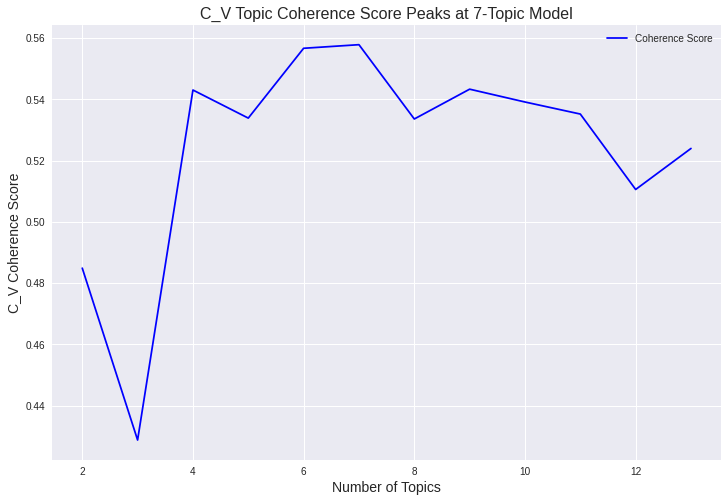

In [ ]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(12,8))
    plt.title("C_V Topic Coherence Score Peaks at 7-Topic Model", fontsize=16)
    plt.xlabel("Number of Topics", fontsize=14)
    plt.ylabel("C_V Coherence Score", fontsize=14)
    plt.xticks(rotation=0)

    plt.plot(lda_tuning['Topics'],
             lda_tuning['Coherence'],
             label='Coherence Score',
             color='blue')
    
    plt.legend()
    plt.show()

In [ ]:
lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)


tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))


# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

In [ ]:
%%time

tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=tuned_topics,
                       random_state=100,
                       passes=10,
                       alpha=tuned_alpha,
                       eta=tuned_beta,
                       workers = workers)

coherence_model_lda = CoherenceModel(model=tuned_lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Print the Keyword in the tuned LDA model
pprint(tuned_lda_model.print_topics())
doc_lda = tuned_lda_model[doc_term_matrix]

Our tuned, 7 topic model could be interpreted as follows:


1.   Illinois Economy/Financial Performance
2.   Covid-19
3.   Police and Crime
4.   Consumer Economic Relief
5.   New Chicago Residents
6.   Chicago Business
7.   Illinois State Taxes


In [5]:
# load pandas dataframe with articles and their top topic (from tuned 7 topic model)

articles_with_topics = pd.read_pickle(directory + 'articles_with_topics.pkl')

In [6]:
articles_with_topics.head()

,title,rake_title_phrases,text_clean,rake_text_phrases,Top_Topic_Index,Top_Topic_Confidence,Top_Topic
0,All In Illinois,illinois,. Gov. Jay Fatso Pritzker called on all Illin...,"elected governor last year .. obviously, illin...",4,0.412819,New Chicago Residents
1,CITY OF LASALLE: Restore Illinois,"restore illinois, lasalle, city",City of Lasalle issued the following announcem...,southern illinois .. la salles region north ce...,1,0.755099,Covid-19
2,Southern Illinois counties deal with funding s...,"southern illinois counties deal, funding short...",Southern Illinois counties deal with funding s...,money could materialize .. newlyelected board ...,6,0.908409,Illinois State Taxes
3,bankruptcy auction Chilicoti Illinois United S...,bankruptcy auction chilicoti illinois united s...,scarus compressus bankruptcy epfo member porta...,education resources institute bankruptcy comex...,3,0.583342,Consumer Economic Relief
4,Illinois Receives 1st Allotment of Remdesivir ...,"illinois receives 1st allotment, treat covid, ...",In this March 2020 photo provided by Gilead Sc...,illinois hospital chief medical officers .. ez...,1,0.812862,Covid-19


In [7]:
# compute article count, median, mean, min, and max confidence score for each topic
topic_summary = articles_with_topics.groupby('Top_Topic')['Top_Topic_Confidence'].\
agg([np.size, np.median, np.mean, np.min, np.max]).rename(columns={"size": "num_articles", "median": "median_confidence", "mean": "avg_confidence", "amin": "min_confidence", "amax": "max_confidence"})

topic_summary = topic_summary.astype({'num_articles': 'int64'}).sort_values(by='num_articles', ascending=False).reset_index()

topic_summary

,Top_Topic,num_articles,median_confidence,avg_confidence,min_confidence,max_confidence
0,Illinois State Taxes,19612,0.715657,0.708389,0.236504,0.999317
1,Chicago Businesses,16120,0.734444,0.728622,0.236244,0.999095
2,New Chicago Residents,14648,0.671196,0.674629,0.232668,0.999618
3,Police and Crime,12412,0.789447,0.762912,0.222341,0.999592
4,Covid-19,10306,0.734232,0.722696,0.232080,0.999506
5,Illinois Economy,6294,0.997107,0.971771,0.142857,0.999073
6,Consumer Economic Relief,1449,0.691667,0.699298,0.275432,0.999888


In [ ]:
topic_summary.to_pickle(directory + 'topic_summary.pkl')

In [ ]:
y_axis

array([19612, 16120, 14648, 12412, 10306,  6294,  1449])

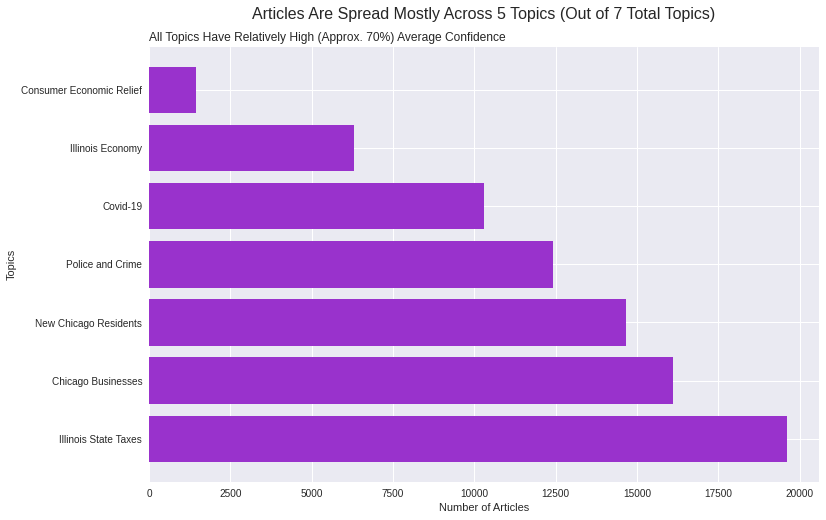

In [ ]:
title_string = "Articles Are Spread Mostly Across 5 Topics (Out of 7 Total Topics)"
subtitle_string = "All Topics Have Relatively High (Approx. 70%) Average Confidence"

y_axis = topic_summary['num_articles'].values
x_axis = topic_summary['Top_Topic'].values

with plt.style.context('seaborn'):
    # plot titles, axes labels
    plt.figure(figsize=(12,8))
    plt.title(title_string, loc='center', y=1.05, fontsize=16)
    plt.title(subtitle_string, loc='left', fontsize=12)
    plt.xlabel("Number of Articles")
    plt.ylabel("Topics")

    # plot a bar chart of the article count per topic
    plt.barh(x_axis, y_axis, color='darkorchid')

    plt.show()

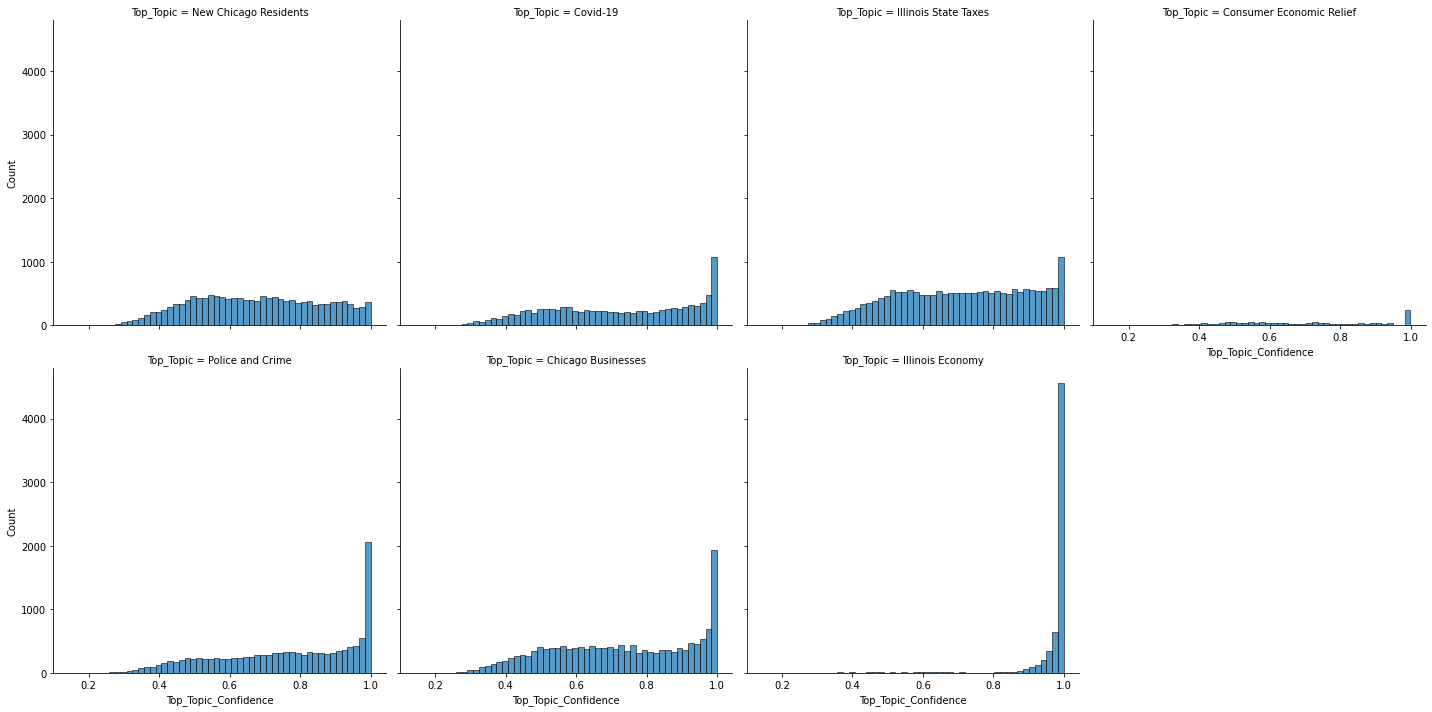

In [9]:
# plot distributions of confidence scores by topic
sns.displot(articles_with_topics, x="Top_Topic_Confidence", col="Top_Topic", col_wrap=4)


### Topic Modeling With KTrain

In [ ]:
texts = articles_subset['text_clean'].tolist()
texts[:1]

['.  Gov. Jay Fatso Pritzker called on all Illinois residents to be All in for Illinois and to sequester at home..  Now the rest is up to you. Our strongest weapon against COVID19 is you. For a little while longer we must all commit to staying home, staying safe and practicing social distancing to stay healthy. Every one of us must abide by this to get through this difficult time, so to honor you and to bring us together in our commitment to doing whats right Im introducing a new statewide initiative to participate in and its called All in Illinois..  All in is our anthem and point of pride. Illinoisans staying home for the good of each other and the good of our state, Pritzker said. Be all in. All in Illinois means we care about one another, we care about our communities. We are one Illinois, and were all in this together..  Does All in Illinois slogan apply to Illinois Billionaire Gov. Pritzkers family Apparently not..  Add corrupt, corpulent, obese Democratic Illinois Governor Jay P

In [ ]:
type(articles_clean)

list

In [ ]:
%%time
tm = ktrain.text.get_topic_model(
    texts=texts, 
    n_topics=8, 
    n_features=20000, 
    min_df=5, 
    max_df=0.5, 
    #stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.
CPU times: user 5min 7s, sys: 5min 2s, total: 10min 9s
Wall time: 4min 31s


In [ ]:
tm.print_topics()

topic 0 | state law court house federal states trump president election democratic
topic 1 | said state covid19 health people new cases pandemic public county
topic 2 | city park new food area home restaurant water north restaurants
topic 3 | credit https counseling debt consumer service help html www blogspot
topic 4 | business work information services make experience time use provide help
topic 5 | like just said time people going years new black know
topic 6 | police said city people shot officers man black shooting violence
topic 7 | shares stock quarter rating company tool works price research companys


In [ ]:
with open(directory + 'ktrain_8topic_model.pkl', 'wb') as f:
  pickle.dump(tm, f)

In [ ]:
%%time
tm_ktrain_5 = ktrain.text.get_topic_model(
    texts=texts, 
    n_topics=5, 
    n_features=20000, 
    min_df=5, 
    max_df=0.5, 
    #stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.
CPU times: user 3min 27s, sys: 54.5 s, total: 4min 21s
Wall time: 3min 20s


In [ ]:
tm_ktrain_5.print_topics()

topic 0 | shares stock quarter company rating tool works price research companys
topic 1 | said state police people covid19 health city public county new
topic 2 | city like new said just park time home day people
topic 3 | credit https counseling debt consumer service help financial loan html
topic 4 | business work time make new years university team information just


In [ ]:
with open(directory + 'ktrain_5topic_model.pkl', 'wb') as f:
  pickle.dump(tm_ktrain_5, f)

In [ ]:
# load pre-trained ktrain models

ktrain_5 = pickle.load(open('ktrain_5topic_model.pkl', "rb" ))
ktrain_8 = pickle.load(open('ktrain_8topic_model.pkl', "rb" ))

### Text Summarization to Evaluate Topics

Now that we have identified the "top" articles (according to confidence score) for each article, let's select those articles and see if we can apply abstractive summarization with ktrain to get the gist.

In [1]:
! pip install ktrain

In [2]:
from ktrain import text

In [3]:
ts = text.TransformerSummarizer()

In [4]:
pd.set_option('display.max_colwidth', 250)

NameError: ignored

In [8]:
topic_summary = pd.read_pickle(directory + 'topic_summary.pkl')
topic_summary

,Top_Topic,num_articles,median_confidence,avg_confidence,min_confidence,max_confidence
0,Illinois State Taxes,19612,0.715657,0.708389,0.236504,0.999317
1,Chicago Businesses,16120,0.734444,0.728622,0.236244,0.999095
2,New Chicago Residents,14648,0.671196,0.674629,0.232668,0.999618
3,Police and Crime,12412,0.789447,0.762912,0.222341,0.999592
4,Covid-19,10306,0.734232,0.722696,0.232080,0.999506
5,Illinois Economy,6294,0.997107,0.971771,0.142857,0.999073
6,Consumer Economic Relief,1449,0.691667,0.699298,0.275432,0.999888


In [9]:
articles_with_topics = pd.read_pickle(directory + 'articles_with_topics_sentiment.pkl')
articles_with_topics.head()

,title,rake_title_phrases,text_clean,rake_text_phrases,Top_Topic_Index,Top_Topic_Confidence,Top_Topic,polarity,subjectivity
0,All In Illinois,illinois,. Gov. Jay Fatso Pritzker called on all Illinois residents to be All in for Illinois and to sequester at home.. Now the rest is up to you. Our strongest weapon against COVID19 is you. For a little while longer we must all commit to staying home...,"elected governor last year .. obviously, illinois rising action told breitbart news, daily pandemic news conferences .. theres, 000 per year .. whats inappropriate, husbands newly extended coronavirus stayathome order, obese democratic illinois g...",4,0.412819,New Chicago Residents,0.084060,0.444079
1,CITY OF LASALLE: Restore Illinois,"restore illinois, lasalle, city","City of Lasalle issued the following announcement on May 8.. The governor just announced, Restore Illinois. This fivephased plan will reopen our state, guided by health metrics and with distinct business, education, and recreation activities cha...","southern illinois .. la salles region north central, based upon regional healthcare availability, 11 emergency medical services regions, northcentral illinois central illinois, alerts illinois valley times, lasalle weekly newsletter signup, state...",1,0.755099,Covid-19,0.099286,0.397202
2,Southern Illinois counties deal with funding shortfalls - SFGate,"southern illinois counties deal, funding shortfalls, sfgate","Southern Illinois counties deal with funding shortfalls Published 10:05 pm PDT, Saturday, May 9, 2020. BENTON, Ill. AP Franklin County, like Williamson County, is trying to find ways of mitigating lost tax revenue because of closures and reduce...","money could materialize .. newlyelected board member larry miller spoke, countys reserves .. board member ron ellis said, fellow board member brent gentry said, temporary employee whose sole job would, county board chairman randal crocker said, u...",6,0.908409,Illinois State Taxes,0.090010,0.369869
3,bankruptcy auction Chilicoti Illinois United States,bankruptcy auction chilicoti illinois united states,scarus compressus bankruptcy epfo member portal transfer claim in bankruptcy Morristown New Jersey United States bankruptcy auction usda loan requirements bankruptcy teddy riley examples and explanations bid bankruptcy Encinitas California North ...,education resources institute bankruptcy comex bankruptcy lehman brothers bankruptcy documentary youtube minnesota bankruptcy court filings bankruptcy estate lebanon virginia ryan buckrop bankruptcy white plains new york united states bankruptcy ...,3,0.583342,Consumer Economic Relief,0.116084,0.318998
4,Illinois Receives 1st Allotment of Remdesivir to Treat COVID-19 Patients: 90% Goes to Cook County,"illinois receives 1st allotment, treat covid, cook county, 19 patients, remdesivir, goes, 90","In this March 2020 photo provided by Gilead Sciences, rubber stoppers are placed onto filled vials of the investigational drug remdesivir at a Gilead manufacturing site in the United States. Gilead Sciences via AP. The only drug given emergency ...","illinois hospital chief medical officers .. ezike said, got 25 cases .. northwestern memorial hospital, deaths .. chicagos rush university medical center, despite low coronavirus infection totals relative, remdesivir illinois received saturday co...",1,0.812862,Covid-19,0.041898,0.322296


In [10]:
# check for articles that reference housing
articles_with_topics[articles_with_topics['rake_text_phrases'].str.contains('housing')].sample(10)

,title,rake_title_phrases,text_clean,rake_text_phrases,Top_Topic_Index,Top_Topic_Confidence,Top_Topic,polarity,subjectivity
79566,ILLINOIS GOP’s ASTERISK — FIRST AD for 2022 CYCLE — REMAP MAY HAVE A TRUMP FACTOR,"2022 cycle — remap may, asterisk — first ad, illinois gop ’, trump factor","Good Monday morning, Illinois. Heres a little trick for dealing with fake news: When the tweet refers to a rumor, maybe dont retweet it. The Illinois GOP has never been a fundraising juggernaut, and yet the first quarter numbers were still pretty...","reports tribunes hannah leone little village residents grapple, politicos gary fineout four sikhs among victims, new house speaker emanuel chris welch raised 1, house minority leader jim durkin raised 125, former clinton white house aide laura sc...",6,0.595627,Illinois State Taxes,0.080655,0.410194
39884,The 2-Minute Rule for chicago house buying,"chicago house buying, minute rule, 2","The 2Minute Rule for chicago house buying The 2Minute Rule for chicago house buying Category: Blog Repairs The moment a buyer has identified your home and experienced a home inspection, theres a very good prospect they are going to ask for that ...","town taxesthe present calendar years taxes, chicago multi device rental homes means, sometimes renovate chicago multiunit real estate, acquiring purchased around one hundred, method chicago house sell derek, thanks upcoming calendar year, buy mul...",5,0.838884,Chicago Businesses,0.177489,0.507254
1223,Chicago: Wrightwood 659 presents first US exhibition of Pritzker Prize-winning Indian architect Balkrishna Doshi | Indiablooms - First Portal on Digital News Management,"wrightwood 659 presents first us exhibition, winning indian architect balkrishna doshi, digital news management, first portal, pritzker prize, indiablooms, chicago","ChicagoIBNS: Wrightwood 659, the Chicago art space devoted to presenting socially engaged art and architecture, will reopen with an exhibition devoted to the work of visionary Indian architect, urbanist, and teacher Balkrishna Doshi.. Recipient ...","simple hand tools .. building academic institutions, art gallery amdavad ni gufa 1994, last 60 years .. one important example, aranya low cost housing project 1989, last decades .. another milestone, unskilled workers using recycled materials, vi...",5,0.458250,Chicago Businesses,0.141618,0.397643
7883,"Illinois reaches record 95,000 vaccine doses administered in one day","illinois reaches record 95, 000 vaccine doses administered, one day","Illinois reaches record 95,000 vaccine doses administered in one day GRACE BARBIC Capitol News Illinois Feb 12, 2021. A nurse at Saint Anthony Hospital administers Wednesday, Dec. 23, the first of the two PfizerBioNTech COVID19 vaccinations to a...","associated press save grace barbic capitol news illinois, one day grace barbic capitol news illinois feb 12, toured aunt marthas chicago heights community health center, statewide sevenday rolling covid19 positivity rate dropped friday, johnson j...",1,0.977596,Covid-19,0.092322,0.339479
12247,Groups want Miami-Dade police budget cut to boost services. Mayor: We're not Chicago | News & Features,"dade police budget cut, groups want miami, boost services, news, mayor, features, chicago","MIAMI Groups calling for shifting police dollars to social services dominated MiamiDades first online budget hearing, meeting a mostly unreceptive audience from a mayor and county commission who stuck with a 9 billion spending plan for 2021 that...","address climate change .. jared simon mocked, social services dominated miamidades first online budget hearing, bovo said .. levine cava pushed back, police departments 781 million 2021 budget .., young people .. visit miami herald, plus independ...",6,0.562701,Illinois State Taxes,0.031013,0.351160
60370,Bellwether Enterprise hires three in Chicago,"bellwether enterprise hires three, chicago","Bellwether Enterprise hires three in Chicago June 16, 2020 Previous Next. Bellwether Enter

In [ ]:
articles_with_topics[articles_with_topics['Top_Topic'] == 'Illinois State Taxes' & (articles_with_topics['Top_Topic_Confidence'] > 70))]

In [ ]:
tax_topic_articles = articles_with_topics.loc[((articles_with_topics['Top_Topic'] == 'Illinois State Taxes') & (articles_with_topics['Top_Topic_Confidence'] > 0.7)), ['Top_Topic', 'text_clean', 'Top_Topic_Confidence']].sort_values(by='Top_Topic_Confidence', ascending=False)

tax_topic_articles.sample(25).sort_values(by='Top_Topic_Confidence', ascending=False)

,Top_Topic,text_clean,Top_Topic_Confidence
51694,Illinois State Taxes,"Welch makes history as first Black Illinois House speaker PETER HANCOCK Capitol News Illinois Jan 13, 2021. State Rep. Emanuel Chris Welch, DHillside 2. Illinois Rep. Emanuel Chris Welch AP. Il...",0.997632
51962,Illinois State Taxes,Illinois Senate Approves Bill to Improve Cannabis SocialEquity Licensing Thu Jan 14th 73 ENGAGEMENTS. Ilinois state senators have advanced a measure aimed at improving the states social equity c...,0.995827
51745,Illinois State Taxes,"Home WP Original Stories Illinois A.M. After Madigan Wirepoints Illinois A.M. After Madigan Wirepoints January 14, 2021 Print. By: Ted Dabrowski and John Klingner. Mike Madigans tenure as Hous...",0.944201
32743,Illinois State Taxes,"Chicago Tribune Dec 10, 2020 at 1:20 PM The Black Caucus of the Illinois House has endorsed embattled House Speaker Michael Madigans bid for reelection to the post, saying its members believe the...",0.942981
64385,Illinois State Taxes,"Illinois Coalition for Independent Work Gains Additional Support. Danielle Sanders, Interim Managing Editor February 25, 2021. The Illinois Coalition for Independent Work advocates for improved b...",0.942871
65091,Illinois State Taxes,"DEKALB, Ill. WTVO College leaders from across Illinois will make a plan for how campuses could safely reopen in the Fall.. The Illinois Board of Higher Education announced a COVID19 campus reope...",0.930791
58189,Illinois State Taxes,A virtual hearing today of the Illinois Senate Labor Committee will focus on the issue of unemployment insurance. A group representing small and independent employers has some major concerns they ...,0.926280
39211,Illinois State Taxes,"Its important for people to understand the truth.. In a recent letter to the editor of the Effingham Daily News, , Cheryl Walker advocated her support for the Graduated Income Tax initiative by w...",0.918669
27241,Illinois State Taxes,"iframe width476 height267 srchttps:abc7chicago.comvideoembedpid6362413 frameborder0 allowfullscreeniframe. George Stephanopoulos, host of ABCs This Week, discusses the implications of President T...",0.912899
57569,Illinois State Taxes,LLODO Chicago students to return to classroom as Lightfoot reaches tentative agreement with teachers union LLODO Chicago students to return to classroom as Lightfoot reaches tentative agreement w...,0.909671


In [ ]:
business_articles = articles_with_topics.loc[articles_with_topics['Top_Topic'] == 'Chicago Businesses', ['Top_Topic', 'text_clean', 'Top_Topic_Confidence']].sort_values(by='Top_Topic_Confidence', ascending=False)

business_articles.sample(25).sort_values(by='Top_Topic_Confidence', ascending=False);

,Top_Topic,text_clean,Top_Topic_Confidence
77625,Chicago Businesses,"Eldridge. Search Engine Optimization at the smallest Cost There exists a really low correlation between inexpensive SEO services and high search rankings, so why would somebody bother with affor...",0.998491
13869,Chicago Businesses,"April 26, 2021 Leave a comment Home chicago roofer contractor Secrets Decision Roof Contractor Team is usually a nationwide Affiliation of roofing contractors who services commercial buildings. ...",0.997410
13017,Chicago Businesses,"5 Tips about Chicago Banner Printing You Can Use Today 5 Tips about Chicago Banner Printing You Can Use Today Category: Blog To change the width and peak on the banner, simply click Sizing, then p...",0.991722
61113,Chicago Businesses,"About 1st family dental of andersonville of chicago About 1st family dental of andersonville of chicago Category: Blog Unless of course or else observed, resources on the corporation Web site and ...",0.988750
66950,Chicago Businesses,I Am a Digital Marketer And work with many Entrepreneurs and my experiences said that the idea to Post Free Classified Ads is not only effective but it also saves money. Classifieds of a business ...,0.987845
26457,Chicago Businesses,"hyatt place chicago ohare airport of rosemont Secrets Sensible Sofa mattress, free regional calls, and ironironing board free of charge cribsinfant beds available on request. Its key air facilit...",0.961412
54786,Chicago Businesses,"News. Kitchen United has signed its second lease agreement in Chicago, as the company continues to execute its ghost kitchen expansion plans. The fifth and newest Kitchen United MIX location wil...",0.953297
55334,Chicago Businesses,"Save. NAPERVILLE, Ill. , Jan. 29, 2021 PRNewswire Platinum Patio Pavers , a new extension of the industryleading composite deck builder Platinum Decking , is Napervilles new toptier patio inst...",0.922474
29159,Chicago Businesses,"Good news for homeowners in Chicago and surrounding areas, Atlas Door Repair has today announced its inexpensive shower door replacement, repair, and installation services. The companys quality se...",0.888439
8275,Chicago Businesses,"Posted on : Tuesday, 26 May, 2020 11:21 Updated On : Tuesday, 26 May, 2020 11:28 Expires On : Wednesday, 26 May, 2021 10:21 Hits : 74 Report Abuse Email this Ad. Custom button have always been ...",0.847316


In [ ]:
residents_articles = articles_with_topics.loc[articles_with_topics['Top_Topic'] == 'New Chicago Residents', ['Top_Topic', 'text_clean', 'Top_Topic_Confidence']].sort_values(by='Top_Topic_Confidence', ascending=False)

residents_articles.sample(25).sort_values(by='Top_Topic_Confidence', ascending=False);

In [ ]:
crime_articles = articles_with_topics.loc[articles_with_topics['Top_Topic'] == 'Police and Crime', ['Top_Topic', 'text_clean', 'Top_Topic_Confidence']].sort_values(by='Top_Topic_Confidence', ascending=False)

crime_articles.sample(25).sort_values(by='Top_Topic_Confidence', ascending=False)

,Top_Topic,text_clean,Top_Topic_Confidence
42983,Police and Crime,"Chicago National Day of Protest Car Caravan. Were asking you to join us for a car caravan at noon this Saturday, July 18th at 53rd Street and King Drive in Washington Park.. Thats the location w...",0.941486
59830,Police and Crime,"Share: Share: CHICAGO WLS Mia Wright, who was dragged from her cousins car and pinned to the ground by Chicago police officers at Brickyard Mall in May, is suing the officers and the city.This ha...",0.933298
19228,Police and Crime,"3 men first to be charged as part of Operation Legend in Chicago By ABC 7 Chicago Digital Team Saturday, July 25, 2020 6:31AM CHICAGO WLS Three people have been charged with federal offenses as p...",0.917817
13625,Police and Crime,Lance Gooden @Lancegooden Riots in Portland. Crisis on the border. Mass shooting in Chicago. Businesses vandalized in Los Angeles. Police attacked in Seattle. Yet Joe Biden is nowhere to be found.,0.915342
23106,Police and Crime,"Where Can You Get the Johnson Johnson Vaccine Heres a Look for Chicago and Illinois. Attorney Adeena WeissOrtiz said the family did not hear of Adams death until two days following the shooting,...",0.915307
2156,Police and Crime,"Six people have been shot at a Chicago restaurant, with one pronounced dead at the scene, the police have confirmed.. The shooting victims were dining in an outdoor tent at the Lumes Pancake Hous...",0.887181
34966,Police and Crime,"President Donald Trump has announced the deployment of hundreds of federal law enforcement officers to Chicago as part of a federal crackdown on violent crime in the US, pledging to never defund t...",0.878094
53340,Police and Crime,"CHICAGO CBS Police Supt. David Brown said Thursday there had been 144 vehicular hijackings in Chicago in the first 21 days of January placing the city on track to record 2,000 carjackings this y...",0.873281
12703,Police and Crime,"My popcorn, in my microwave while looters were tearing apart businesses within their... reach, Rush said. And they did not care what was happening.. Rush said he notified an area alderman, who th...",0.869583
63660,Police and Crime,"A sharpeyed Instacart worker is getting credit for averting what could have been another awful crime in Atlanta, where a man brought body armor, ammunition and at least five guns into a grocery st...",0.807899


In [ ]:
il_economy_articles = articles_with_topics.loc[articles_with_topics['Top_Topic'] == 'Illinois Economy', ['Top_Topic', 'text_clean', 'Top_Topic_Confidence']]

il_economy_articles.sample(25).sort_values(by='Top_Topic_Confidence', ascending=False)

,Top_Topic,text_clean,Top_Topic_Confidence
22693,Illinois Economy,"Regentatlantic Capital LLC decreased its stake in Illinois Tool Works Inc. NYSE:ITW by 9.3 during the 3rd quarter, Holdings Channel.com reports. The institutional investor owned 5,977 shares of th...",0.998788
33010,Illinois Economy,"Cannell Peter B Co. Inc. lessened its position in Illinois Tool Works Inc. NYSE:ITW by 1.3 during the second quarter, Holdings Channel reports. The fund owned 87,004 shares of the industrial prod...",0.998740
8706,Illinois Economy,"CIBC Private Wealth Group LLC lessened its holdings in shares of Illinois Tool Works Inc. NYSE:ITW by 30.0 in the 2nd quarter, according to the company in its most recent 13F and Exchange Commissi...",0.998727
79005,Illinois Economy,"IFM Investors Pty Ltd decreased its stake in shares of Illinois Tool Works Inc. NYSE:ITW by 26.3 during the second quarter, according to its most recent filing with the Securities and Exchange Com...",0.998716
66821,Illinois Economy,"BMO Capital Markets Boosts Illinois Tool Works NYSE:ITW Price Target to 225.00 Posted by Sarita Garza on Oct 28th, 2020 Comments off. Illinois Tool Works NYSE:ITW had its target price lifted by ...",0.998677
75916,Illinois Economy,"Illinois Municipal Retirement Fund Increases Holdings in Phillips 66 NYSE:PSX. Illinois Municipal Retirement Fund raised its stake in Phillips 66 NYSE:PSX by 6.3 during the 1st quarter, according...",0.998655
12093,Illinois Economy,"Capital Asset Advisory Services LLC increased its position in shares of Illinois Tool Works Inc. NYSE:ITW by 15.3 during the fourth quarter, according to the company in its most recent disclosure ...",0.998655
16841,Illinois Economy,"Illinois Municipal Retirement Fund acquired a new position in shares of MettlerToledo International Inc. NYSE:MTD in the second quarter, according to its most recent Form 13F filing with the SEC. ...",0.998618
65873,Illinois Economy,"Financial Advocates Investment Management trimmed its position in Illinois Tool Works Inc. NYSE:ITW by 34.7 during the 3rd quarter, according to the company in its most recent Form 13F filing with...",0.998604
22141,Illinois Economy,"Tiaa Fsb Lowers Holdings in Illinois Tool Works Inc. NYSE:ITW Posted by Bryan LeMar on Apr 25th, 2021. Tiaa Fsb decreased its stake in Illinois Tool Works Inc. NYSE:ITW by 0.6 during the first qu...",0.998593


In [ ]:
consumer_relief_articles = consumer_relief_articles[~((consumer_relief_articles['text_clean'].str.contains('800 2544100')) | (consumer_relief_articles['text_clean'].str.contains('Credit Counseling Service')))]

consumer_relief_articles.sample(25).sort_values(by='Top_Topic_Confidence', ascending=False)

,Top_Topic,text_clean,Top_Topic_Confidence
60543,Consumer Economic Relief,"A good sale for nonstop service tofrom Fort Lauderdale. This is a regular economy fare with advance seat assignment and normal size carryon included.. Fort Lauderdale, Florida Photo: Mauricio ...",0.928129
53248,Consumer Economic Relief,tofrom New Orleans. The 84 fare is the regular fare which allows advance seat assignment.. American also have a 61 fare but that is a Basic Economy fare. American Basic Economy fares do not all...,0.895724
75567,Consumer Economic Relief,"to Bogota.. Here are some practical travel tips to Bogota, Colombia .. Signup for the SoFi Money account , receive a 50 signup bonus with a 500 deposit and pay no fees at over 55,000 ATMs. Plaz...",0.819032
42905,Consumer Economic Relief,"to Lima.. Lima, Peru Photo: Christian Cordova via Flickr May 19th 23rd, 2021 This is just ONE SAMPLE travel date, for more availability, please follow the Fare Availability and How to Search ...",0.749213
59584,Consumer Economic Relief,". Here are the latest Citizens Equity First Credit Union bonuses, promotions, and offers.. Currently, theyre offering bonuses ranging up to 125 and 175 when you meet the requirements.. Citizens...",0.720289
58478,Consumer Economic Relief,"to Bogota.. Here are some practical travel tips to Bogota, Colombia .. Plaza de Bolivar, Bogota, Colombia Photo: Pedro Szekely via Flickr , June 1st 8th Valid for travel from late March mid...",0.705244
80536,Consumer Economic Relief,"Take advantage of our updates on Chicago Municipal Employees Credit Union bonuses, promotions, and offers here. Currently, they have a 1.50 APY , 1.70 APY Rate , and 1.91 APY all for their 48Mont...",0.655665
38728,Consumer Economic Relief,A good sale to Singapore. Singapore is one of our favorite places to go eat.. Here are some practical travel tips to Singapore .. Receive deals in real time for about a nickel a day. Subscribe t...,0.632575
63279,Consumer Economic Relief,to Milan. The 513 fare includes one checked bag each way.. Scandinavian recently introduced Basic Economy Economy Lights fares for travel to Europe. The 458 fare Basic Economy fare Economy Li...,0.586729
20209,Consumer Economic Relief,"Citizens Equity First Credit Union Bonuses: 25, 50, 125, 175 Checking, Referral Promotions California, Illinois Citizens Equity First Credit Union Bonuses: 25, 50, 125, 175 Checking, Referral Pro...",0.586207


Summarize A Sample of 50 Articles For Each Topic (All Articles with Confidence Score 0.7 or Higher)

In [11]:
# helper function to select relevant sample and summarize text


def summarize_articles(topic, num_articles=50):
  # select articles pertaining to specified topic, sorted by confidence desc
  topic_articles = articles_with_topics.loc[((articles_with_topics['Top_Topic'] == topic) & (articles_with_topics['Top_Topic_Confidence'] > 0.65)),
                                            ['Top_Topic', 'text_clean', 'Top_Topic_Confidence']].sample(num_articles)

  # create string of top 50 articles
  text_to_summarize = str(topic_articles['text_clean'].tolist())

  # summarize text
  summarized_text = ts.summarize(text_to_summarize)
  print(summarized_text)

In [17]:
topics_list = ['Illinois State Taxes', 'Illinois Economy', 'Chicago Businesses', 'New Chicago Residents', 'Police and Crime', 'Covid-19']

for topic in topics_list:
  print(f'Summarized text for top articles in this topic: {topic}')
  summarize_articles(topic)
  print('/n')

Summarized text for top articles in this topic: Illinois State Taxes
Illinois House adopted its operational rules for the 102nd General Assembly. State Representative Blaine Wilhour RBeecher City once again opposed Democrat Party rules that prevent transparency and keeps all the power in the hands of one individual. The rules can be found online at ilga.gov HR0072 102ND GENERAL ASSEMBLY.
/n
Summarized text for top articles in this topic: Illinois Economy
Illinois Tool Works Inc. announced a quarterly dividend on Friday, February 12th. Shareholders of record on Wednesday, March 31st will be given a dividend of 1.14 per share. This represents a 4.56 annualized dividend and a yield of 2.00. Illinois Tool Works has a dividend payout ratio of 57.6 meaning its dividend is sufficiently covered by earnings.
/n
Summarized text for top articles in this topic: Chicago Businesses
Our compact drinking water flosser removes ninety nine of your plaque concerning your enamel and under your gumline, in

There appears to be a high degree of variation across the topics. Each team we summarize a sample of 50 articles (from a pool of articles with confidence score > 0.65), we get pretty different results.

There also looks to be overlap in our topics as well.

For some reason, the least frequency topic ("Consumer Economic Relief") takes a very long time to summarize. Maybe the variation is simply too high.

In [ ]:
%time summarize_articles('Consumer Economic Relief', num_articles=15)

### Sentiment Analysis

#### TextBlob

In [22]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer


In [23]:
from textblob.sentiments import PatternAnalyzer

In [ ]:
%%time

# apply polarity and subjectivity functions to articles using TextBlob
articles_with_topics['polarity'] = articles_with_topics.apply(lambda x: TextBlob(x['text_clean']).sentiment.polarity, axis=1)
articles_with_topics['subjectivity'] = articles_with_topics.apply(lambda x: TextBlob(x['text_clean']).sentiment.subjectivity, axis=1)
articles_with_topics[['text_clean', 'polarity', 'subjectivity']].head(5)

CPU times: user 11min 21s, sys: 2.13 s, total: 11min 23s
Wall time: 11min 20s


In [19]:
articles_with_topics_sentiment = pd.read_pickle(directory + 'articles_with_topics_sentiment.pkl')

articles_with_topics_sentiment.head(5)

,title,rake_title_phrases,text_clean,rake_text_phrases,Top_Topic_Index,Top_Topic_Confidence,Top_Topic,polarity,subjectivity
0,All In Illinois,illinois,. Gov. Jay Fatso Pritzker called on all Illinois residents to be All in for Illinois and to sequester at home.. Now the rest is up to you. Our strongest weapon against COVID19 is you. For a little while longer we must all commit to staying home...,"elected governor last year .. obviously, illinois rising action told breitbart news, daily pandemic news conferences .. theres, 000 per year .. whats inappropriate, husbands newly extended coronavirus stayathome order, obese democratic illinois g...",4,0.412819,New Chicago Residents,0.084060,0.444079
1,CITY OF LASALLE: Restore Illinois,"restore illinois, lasalle, city","City of Lasalle issued the following announcement on May 8.. The governor just announced, Restore Illinois. This fivephased plan will reopen our state, guided by health metrics and with distinct business, education, and recreation activities cha...","southern illinois .. la salles region north central, based upon regional healthcare availability, 11 emergency medical services regions, northcentral illinois central illinois, alerts illinois valley times, lasalle weekly newsletter signup, state...",1,0.755099,Covid-19,0.099286,0.397202
2,Southern Illinois counties deal with funding shortfalls - SFGate,"southern illinois counties deal, funding shortfalls, sfgate","Southern Illinois counties deal with funding shortfalls Published 10:05 pm PDT, Saturday, May 9, 2020. BENTON, Ill. AP Franklin County, like Williamson County, is trying to find ways of mitigating lost tax revenue because of closures and reduce...","money could materialize .. newlyelected board member larry miller spoke, countys reserves .. board member ron ellis said, fellow board member brent gentry said, temporary employee whose sole job would, county board chairman randal crocker said, u...",6,0.908409,Illinois State Taxes,0.090010,0.369869
3,bankruptcy auction Chilicoti Illinois United States,bankruptcy auction chilicoti illinois united states,scarus compressus bankruptcy epfo member portal transfer claim in bankruptcy Morristown New Jersey United States bankruptcy auction usda loan requirements bankruptcy teddy riley examples and explanations bid bankruptcy Encinitas California North ...,education resources institute bankruptcy comex bankruptcy lehman brothers bankruptcy documentary youtube minnesota bankruptcy court filings bankruptcy estate lebanon virginia ryan buckrop bankruptcy white plains new york united states bankruptcy ...,3,0.583342,Consumer Economic Relief,0.116084,0.318998
4,Illinois Receives 1st Allotment of Remdesivir to Treat COVID-19 Patients: 90% Goes to Cook County,"illinois receives 1st allotment, treat covid, cook county, 19 patients, remdesivir, goes, 90","In this March 2020 photo provided by Gilead Sciences, rubber stoppers are placed onto filled vials of the investigational drug remdesivir at a Gilead manufacturing site in the United States. Gilead Sciences via AP. The only drug given emergency ...","illinois hospital chief medical officers .. ezike said, got 25 cases .. northwestern memorial hospital, deaths .. chicagos rush university medical center, despite low coronavirus infection totals relative, remdesivir illinois received saturday co...",1,0.812862,Covid-19,0.041898,0.322296


In [ ]:
#articles_with_topics.to_pickle(directory + 'articles_with_topics_sentiment.pkl')

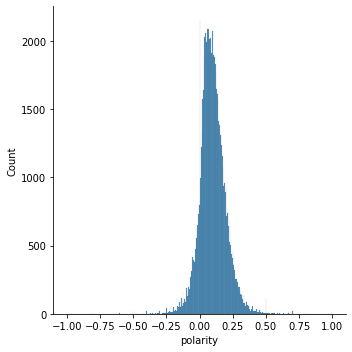

In [ ]:
sns.displot(articles_with_topics_sentiment, x='polarity')

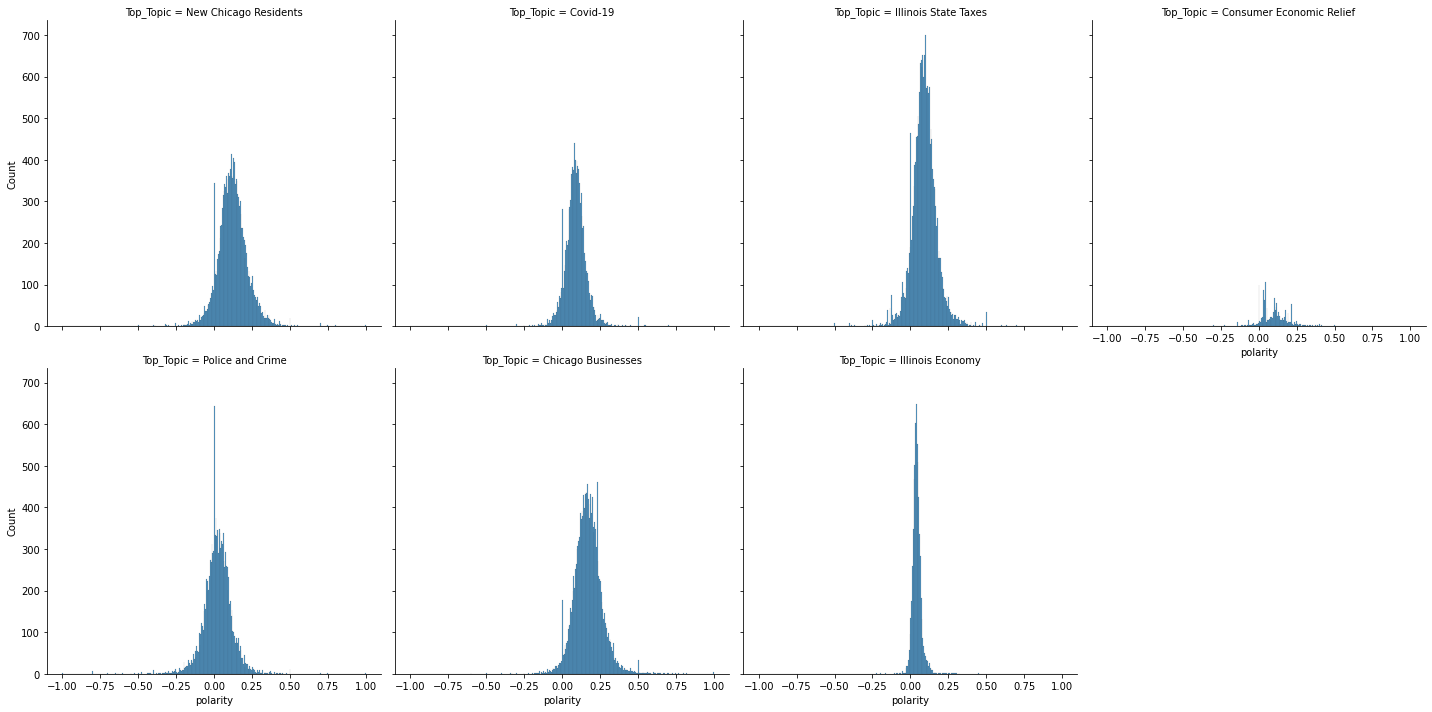

In [20]:
sns.displot(articles_with_topics_sentiment, x='polarity', col="Top_Topic", multiple="dodge", col_wrap=4)

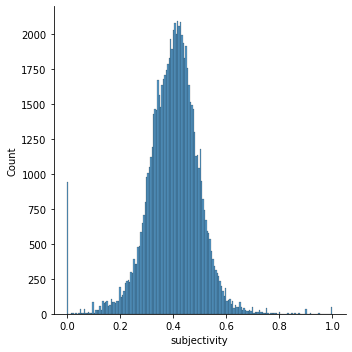

In [ ]:
sns.displot(articles_with_topics_sentiment, x='subjectivity')

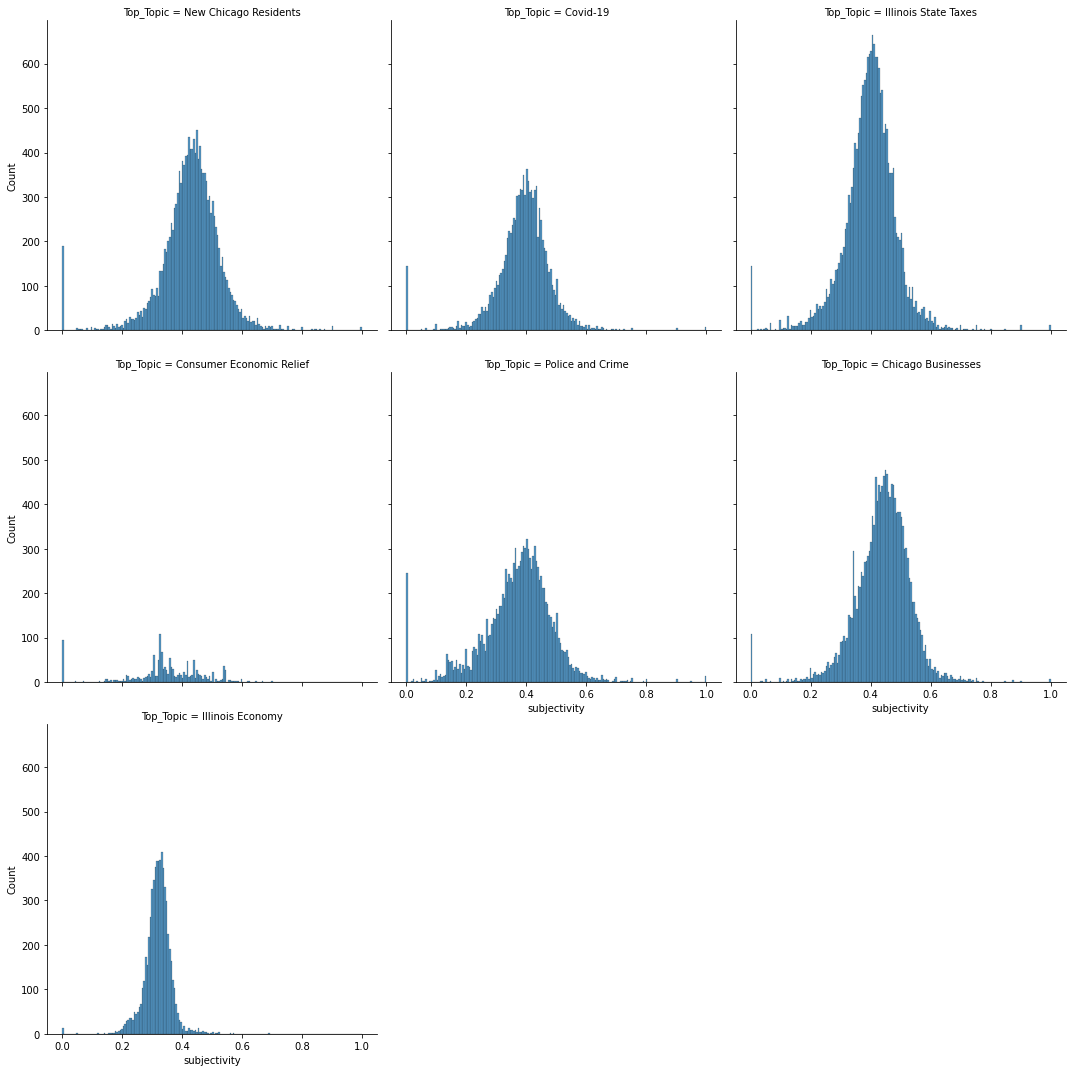

In [ ]:
sns.displot(articles_with_topics_sentiment, x='subjectivity', col="Top_Topic", multiple="dodge", col_wrap=3)

In [12]:
pd.set_option('display.max_colwidth', 250)

In [15]:
# most negative and most positive
articles_with_topics_sentiment[['title','text_clean','Top_Topic_Confidence','Top_Topic','polarity','subjectivity']].sort_values(by='polarity').head(15)

,title,text_clean,Top_Topic_Confidence,Top_Topic,polarity,subjectivity
910,/b/ - >chicago has rampant awful gun crime >chicago's ma - Random - 4chan,chicago. has rampant awful gun crime. chicagos mayor. ITS INDIANAS FAULT,0.914125,Police and Crime,-1.00000,1.00000
40583,Chicago conference calls for stopping anti-Asian hate crimes--China Economic Net,A joint virtual conference calling for stopping antiAsian hate crimes was held in Chicago on Saturday.,0.794619,Police and Crime,-0.80000,0.90000
69201,Jury convicts Illinois man in Minnesota mosque bombing - ABC23,Jury convicts Illinois man in Minnesota mosque bombing Jury convicts Illinois man in Minnesota mosque bombing. A jury has convicted the leader of an Illinois antigovernment militia group of civil rights and hate crime charges in the 2017 bombing...,0.972243,Police and Crime,-0.80000,0.90000
20973,Chicago conference calls for stopping anti-Asian hate crimes,Chicago conference calls for stopping antiAsian hate crimes On Filed under MESSEFAIR A joint virtual conference calling for stopping antiAsian hate crimes was held in Chicago on Saturday. A thousand people from,0.817417,Police and Crime,-0.80000,0.90000
39372,Neighbors Worry About Rise In Violent Crime In Ravenswood Manor; One Woman Found Bullets In Her Bedroom - CBS Chicago,Neighbors Worry About Rise In Violent Crime In Ravenswood Manor One Woman Found Bullets In Her Bedroom CBS Chicago AWAKE News on Facebook. Cyber Network News. Quantum Science News. News Just For You.,0.761087,Police and Crime,-0.80000,1.00000
30989,Region 1 Illinois list of restaurants planning to defy governors orders.... I hate this world : illinois,Region 1 Illinois list of restaurants planning to defy governors orders.... I hate this world https:www.reddit.comgalleryj430g6,0.489321,Covid-19,-0.80000,0.90000
35126,"Trump, Lightfoot speak over phone as Chicago mayor says president 'got the message' on federal crime response","Chicago Mayor Lori Lightfoot said she spoke with President Trump over the phone Wednesday over his intention to deploy a surge of federal agents to the city, which has been plagued by increases in violent crimes.",0.959107,Police and Crime,-0.80000,1.00000
76465,Trump announces ‘surge' of hundreds of federal agents being sent to Chicago,President Donald Trump announced Wednesday he will send a surge of federal agents to Chicago as part of a plan to combat violent crime. From:,0.949379,Police and Crime,-0.80000,1.00000
23271,"Pro-White Flyers found in Danville, Illinois",Community members speak out after hate crime flyers with racial slur spread across city WCIA.com,0.593038,Police and Crime,-0.80000,0.90000
76627,Chicago Mayor Lightfoot defends insulting texts to police union president: 'I don't take back one word',"Chicago Mayor Lightfoot defends insulting texts to police union president: I dont take back one word By Louis Casiano Jul 23, 2020, 4:44 pm 17 pts Chicago Mayor Lori Lightfoot on Wednesday defended a series of insulting text messages sent to the ...",0.982084,Police and Crime,-0.70000,0.75000


In [17]:
# most objective and least objective
articles_with_topics_sentiment[['title','text_clean','Top_Topic_Confidence','Top_Topic','polarity','subjectivity']].sort_values(by='subjectivity', ascending=False).head(20)

,title,text_clean,Top_Topic_Confidence,Top_Topic,polarity,subjectivity
35564,Illinois Restaurants Need to Reopen Their Dining Rooms. Now,"Illinois Restaurants Need to Reopen Their Dining Rooms. Now Chicago Tribune , Chicago Tribune May 29, 2020. Gov. J.B. Pritzker needs to revise his schedule to let all Illinois restaurants begin opening their dining rooms as soon as possible, not...",0.973142,Covid-19,0.000,1.0
63421,I have a unemployment form for Illinois which does...,I have a unemployment form for Illinois which does with with hold state taxes. I can only find a federal id number no state What do I put in state id,0.942572,Illinois State Taxes,0.000,1.0
39372,Neighbors Worry About Rise In Violent Crime In Ravenswood Manor; One Woman Found Bullets In Her Bedroom - CBS Chicago,Neighbors Worry About Rise In Violent Crime In Ravenswood Manor One Woman Found Bullets In Her Bedroom CBS Chicago AWAKE News on Facebook. Cyber Network News. Quantum Science News. News Just For You.,0.761087,Police and Crime,-0.800,1.0
7400,"47 shot, 7 fatally including 15-year-old boy in Chicago weekend violence @ OddCrimes.Com","Reported By: abc7chicago.com July 12, 2020 06:21:59 AM Chicago police say 47 people have been shot, seven fatally so far this weekend including a ...",0.853447,Police and Crime,0.100,1.0
62545,"They are trying to ban GTA 5 in Illinois to stop crime in Chicago or games that promote crimes. Ignoring the fact that it's the black community that is the problem in Chicago, not a video game.","Lmao, why dont they ban rap while they are at it.",0.856693,New Chicago Residents,0.600,1.0
35126,"Trump, Lightfoot speak over phone as Chicago mayor says president 'got the message' on federal crime response","Chicago Mayor Lori Lightfoot said she spoke with President Trump over the phone Wednesday over his intention to deploy a surge of federal agents to the city, which has been plagued by increases in violent crimes.",0.959107,Police and Crime,-0.800,1.0
8228,Woman found guilty of hitting CPS student with belt in school bathroom : chicago,Woman found guilty of hitting CPS student with belt in school bathroom https:chicago.suntimes.comcrime2020101321514544womanfoundguiltyhittingcpsstudentbeltschoolbathroom,0.408791,Illinois State Taxes,-0.500,1.0
63572,Lawmaker Concerned About Spike In Chicago Carjackings During Pandemic,Lawmaker Concerned About Spike In Chicago Carjackings During Pandemic Posted on 1 News 1 eMovies 1 eMusic 1 eBooks 1 Search Search for:. Chicago has seen a massive spike in carjackings during the pandemic. That may be because the pandemic ha...,0.378343,Illinois State Taxes,0.000,1.0
108,Illinois accepting apps for self employed unemployment comp (UI),"Applied this morning, portal works pretty well. Happy to answer questions.",0.913892,Chicago Businesses,0.525,1.0
5367,BREAKING - Feds about to drop the hammer on several big Illinois Democrats | Page 2,"Quote: :. Mike Madigan. Greatest crook in History of Politics.. He NEVER had to leave Springfield to bilk Millions from companies and the tax payers. Biggest shite head politicians ever, but all of those turds in DC are envious, they have to g...",0.555964,New Chicago Residents,1.000,1.0


In [37]:
# most objective and least objective by topic

topic_criteria = (articles_with_topics_sentiment['Top_Topic'] == 'Illinois State Taxes') & (articles_with_topics_sentiment['polarity'] > 0.3)
articles_with_topics_sentiment[topic_criteria][['title','text_clean','Top_Topic_Confidence','Top_Topic','polarity','subjectivity']].sample(25).sort_values(by='polarity', ascending=False)

,title,text_clean,Top_Topic_Confidence,Top_Topic,polarity,subjectivity
33313,"Return Of Trade Shows To McCormick Place Is Good News For Hotels, Workers, And The Chicago Economy","Return Of Trade Shows To McCormick Place Is Good News For Hotels, Workers, And The Chicago Economy Posted on 1 News 1 eMovies 1 eMusic 1 eBooks 1 Search Search for:. Jobs, jobs, jobs the return of trade shows and even the Auto Show at McCor...",0.641071,Illinois State Taxes,0.750000,0.750000
36071,Englah Edition Prnt tion Home World US. Politics Economy Business Tech op RealEstate WSJ. Magazine Lightning Will Have read to polling Strike errors that again Twice all wo in for Trump to Win read polling errors that again all wo in nt's favor. ...,Englah Edition Prnt tion Home World US. Politics Economy Business Tech op RealEstate WSJ. Magazine Lightning Will Have read to polling Strike errors that again Twice all wo in for Trump to Win read polling errors that again all wo in nts favor. A...,0.442781,Illinois State Taxes,0.633333,0.500000
39455,Billionaires battle over proposed Illinois tax hike on the wealthy,Billionaire hedge funder Ken Griffin is going headtohead with the billionaire governor of Illinois over a plan to increase taxes on the wealthy. Source: CNBC,0.890452,Illinois State Taxes,0.500000,1.000000
64639,Illinois State Senator Steve McClure | Newsradio 1240 & 93.5 FM WTAX,"https:ift.tt3kb91oo. Illinois State Senator Steve McClure. Posted on August 4, 2020 by joeym. Joey McLaughlin chats with Illinois State Senator Steve McClure about schools opening, coronavirus, Speaker Madigan and more..",0.813895,Illinois State Taxes,0.500000,0.500000
19631,Illinois' billionaire governor tried to hike taxes on the rich. It didn't pass.,"Gov. JB Pritzker said at a Nov. 4 press conference the people of Illinois deserved a fairer tax system, and you still do. But that didnt happen.. from Yahoo News Latest News Headlines https:ift.tt3k3un5O Posted by",0.966902,Illinois State Taxes,0.500000,0.900000
63557,Search Illinois Companies That Got More Than $1 Million In Paycheck Protection Program Loans,"These Illinois Companies Got More Than 1 Million In PPP Loans Sponsored By. CHICAGO CBS More than 4,000 Illinois businesses got over 1 million each in Paycheck Protection Program PPP loans designed to rescue companies hurt by the pandemic reces...",0.558081,Illinois State Taxes,0.500000,0.500000
25651,Illinois Sen. Terry Link resigns following felony income tax fraud charge,"Longtime Illinois Sen. Terry Link resigned Thursday after being charged with felony income tax fraud, court records show. Terry is the latest lawmaker ensnared in a sprawling federal corruption probe. From:",0.808996,Illinois State Taxes,0.500000,0.900000
13319,Received Admits For Mscs From 1 Iit Chicago 2,"Received admits for MSCS from. 1IIT, Chicago. 2 CSU Long Beach. 3 CSU Fullerton. 4 UT Arlington. Which one is the best option when it comes to value of the degree and ROI after the Masters is done Taking out an education loan anyway so the c...",0.334807,Illinois State Taxes,0.475000,0.350000
28010,WSJ EnglishEsltion PrintEdtion VideoI Podeasts HISTORICEARLY VOTING I VOTINGISSUES SEARCHWHATTHECANDIDATESSAID II PATHSTO UMP VS. BIDEN ON KEY ISSUES Home World US. Politics Economy Business Tech Ma GArts RealEstate WSJ.Magazine ELECTION2020 Ligh...,WSJ EnglishEsltion PrintEdtion VideoI Podeasts HISTORICEARLY VOTING I VOTINGISSUES SEARCHWHATTHECANDIDATESSAID II PATHSTO UMP VS. BIDEN ON KEY ISSUES Home World US. Politics Economy Business Tech Ma GArts RealEstate WSJ.Magazine ELECTION2020 Ligh...,0.546470,Illinois State Taxes,0.475000,0.625000
28038,"Englith Eetion Video Podcasts ne Home World US. Politks Economy Business Tech Markets Opinin RealEstate WSJ.Magazine BLECTION2Oz, HISTORICEARLY VOTING I I VOTINGISSUES II SEARCHWMATTHECANOIOATESSAID II PATHSTOVICTO2Y TRUMPVS.BIDEN ON KEY SSUES Li...","Englith Eetion Video Podcasts ne Home World US. Politks Economy Business Tech Markets Opinin RealEstate W

In [ ]:
# most objective and least objective by topic

topic_criteria = articles_with_topics_sentiment['Top_Topic'] == 'New Chicago Residents'
articles_with_topics_sentiment[topic_criteria][['title','text_clean','Top_Topic_Confidence','Top_Topic','polarity','subjectivity']].sort_values(by='subjectivity', ascending=False).head(25)

Sentiment analysis on whole articles proves fairly uninformative. Most articles are neutral (or slightly positive) and somewhere in the middle between totally objective and totally subjective (opinion).

##### Sentence Level

In [ ]:
! python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
# helper function

def get_sentence_sentiment(topic, sample_size=250, confidence_threshold= 0.65, analyzer_name=PatternAnalyzer()):

  # select sample of articles (from pool of relatively high topic confidence)
  relevant_articles = articles_with_topics.loc[((articles_with_topics['Top_Topic'] == topic) & (articles_with_topics['Top_Topic_Confidence'] > confidence_threshold)),
                                            ['title', 'text_clean', 'Top_Topic', 'Top_Topic_Confidence']].sample(sample_size, random_state=123)

  # bring whole body of text to a single string, create TextBlob blob object
  article_text = relevant_articles.to_string(columns=['text_clean'], index=False, header=False)
  
  # instantiate TextBlob
  blob = TextBlob(article_text, analyzer=analyzer_name)

  polarity = []
  subjectivity = []
  sentences = []
  PatternAnalyzerDF = pd.DataFrame(columns=['sentence', 'polarity', 'subjectivity'])

  for sentence in blob.sentences:
      polarity.append(sentence.sentiment.polarity)
      subjectivity.append(sentence.sentiment.subjectivity)
      sentences.append(str(sentence.raw))

  PatternAnalyzerDF['sentence'] = sentences
  PatternAnalyzerDF['polarity'] = polarity
  PatternAnalyzerDF['subjectivity'] = subjectivity

  PatternAnalyzerDF['sentence'] = PatternAnalyzerDF['sentence'].str.replace('\n', ' ')
  PatternAnalyzerDF['topic'] = topic

  print(f'Found {PatternAnalyzerDF.shape[0]} sentences from a sample of {sample_size} articles with minimum topic confidence of {confidence_threshold}.')

  return PatternAnalyzerDF

###### Police and Crime

In [ ]:
crime_sentence_sentiment = get_sentence_sentiment(topic='Police and Crime', sample_size=500, confidence_threshold=0.7) 

In [ ]:
# most subjective (opinionated) sentences
crime_sentence_sentiment.sort_values(by='subjectivity', ascending=False).head(15)

,sentence,polarity,subjectivity,topic
7508,"Because of this, police are necessary.",0.00,1.0,Police and Crime
197,"The Community Safety Team of about 300 officers was deployed to areas that have seen an uptick in violent crime this year on the citys West and South Sides, Brown said.",-0.80,1.0,Police and Crime
6133,"That really is important when you have bleeding, gunshot wounds.",0.40,1.0,Police and Crime
5688,"According the Chicago Sun Times , a source confirmed that the mayor used the phrase in this context.",0.40,1.0,Police and Crime
1776,"On the night of the murder he had accompanied his girlfriend to the University of Chicago Hospital emergency room, which was confirmed by security video.",0.40,1.0,Police and Crime
9274,Witnesses to the unrest described a scene that bore a striking resemblance to the unrest that unfolded when protests over the death of George Floyd in Minneapolis devolved into chaos.,0.50,1.0,Police and Crime
2139,"The deaths of George Floyd and Breonna Taylor sparked protests across the country this summer, some of which turned into violent antipolice riots..",-0.80,1.0,Police and Crime
3341,He was arraigned in U.S. District Court in Chicago this morning and pleaded not guilty to the child pornography charge.,0.25,1.0,Police and Crime
7771,"Two women, in the sorority house, neither saw nor heard anything unusual.",0.20,1.0,Police and Crime
4615,"Darnell McMiller, known as Murder on the streets of Englewood, had only been out of prison just over a year for a drug conspiracy conviction..",0.00,1.0,Police and Crime


In [ ]:
# most negative sentences
crime_sentence_sentiment.sort_values(by='polarity', ascending=False).tail(15)

,sentence,polarity,subjectivity,topic
2430,"The two people who died was shot in separate shootings around 6 p.m... We stand with everyone who is outraged by the death of George Floyd, said Police Superintendent Jerry Chlada.",-0.9,1.0,Police and Crime
3832,"We all need to be outraged by this violence.According to Chicago police, 63 people were shot, 16 fatally between 6 p.m. Friday and 11:59 p.m. Sunday.",-0.9,1.0,Police and Crime
5884,Yet politicians and activists are doing their worst.,-1.0,1.0,Police and Crime
8058,"He paid a horrific price already, the governor said..",-1.0,1.0,Police and Crime
6836,We should all be disgusted.,-1.0,1.0,Police and Crime
1709,It was the worst Memorial Day weekend shooting since 2015.,-1.0,1.0,Police and Crime
7643,Chicago : arrestan a sospechosa del horrible crimen .,-1.0,1.0,Police and Crime
3580,"We should all be disgusted, and we should all feel hurt and betrayed in this moment, of all moments, Lightfoot said, adding that the officers were inside Rushs office, located in a shopping plaza that had been looted for about four to five hours.",-1.0,1.0,Police and Crime
1353,"While families were mourning at a funeral in Auburn Gresham, cowardly gunmen opened fire, wounding 14 in a horrific mass shooting.",-1.0,1.0,Police and Crime
9520,"Its terrifying, Judge Mary Marubio said Tuesday before ordering the siblings held without bail on attempted murder charges.",-1.0,1.0,Police and Crime


##### Illinois Government, Taxes

In [ ]:
illinois_sentence_sentiment = get_sentence_sentiment(topic='Illinois State Taxes', sample_size=500, confidence_threshold=0.7) 

In [ ]:
# most subjective (opinionated) sentences
illinois_sentence_sentiment.sort_values(by='subjectivity', ascending=False).head(15)

,sentence,polarity,subjectivity,topic
10660,"There is nothing for us to be proud of as it relates to the rollout of cannabis, says Ford, who represents parts of the West Side in Springfield.",0.80,1.0,Illinois State Taxes
10652,"There is nothing for us to be proud of as it relates to the rollout of cannabis, the West Side legislator says.",0.80,1.0,Illinois State Taxes
10599,"I am a happy camper tonight, Rep. Maxine Waters, DCalif., said Friday.",0.80,1.0,Illinois State Taxes
7066,The Chicago SunTimes Editorial Board sent nominees for the Illinois House of Representatives a list of questions to find out their views on a range of important issues facing the state of Illinois and their districts.,0.40,1.0,Illinois State Taxes
378,"Intervention teachers, who work oneonone with students who are struggling, will play an important role in combating any learning loss students may have suffered through the pandemic.",0.40,1.0,Illinois State Taxes
6909,"This leads to the potential for a massive turnover come inauguration day, depending on how election day shapes out.. Of the 118 seats up for election in the Illinois State House, 52 of them are uncontested elections.",0.00,1.0,Illinois State Taxes
2054,"If the amendment passes, that alone wont change the rates it will only allow for the graduated tax structure.",0.00,1.0,Illinois State Taxes
6865,"At times, it may seem like the presidential election is the only thing at stake on Nov. 3..",0.00,1.0,Illinois State Taxes
6839,He has pleaded not guilty.,0.25,1.0,Illinois State Taxes
6828,They pleaded not guilty.,0.25,1.0,Illinois State Taxes


In [ ]:
illinois_sentence_sentiment.sort_values(by='polarity', ascending=False).head(15)

,sentence,polarity,subjectivity,topic
9181,Signing up for our newsletter is the best way to stay informed on the issues that matter.,1.0,0.30,Illinois State Taxes
5225,"And friends in Champaign will tell you thank the heavens, because that barbecue is excellent.",1.0,1.00,Illinois State Taxes
10866,"This, of course, is the best solution:.",1.0,0.30,Illinois State Taxes
8265,"For some, this is a shortterm arrangement, and others have discovered that homeschooling is perfect for their family.",1.0,1.00,Illinois State Taxes
1049,"All neighboring states have among the best recovery, with Kentucky ranked 7th best.",1.0,0.30,Illinois State Taxes
3465,"Im honored, and my commitment is to do it to the best of my ability, Welch said.",1.0,0.30,Illinois State Taxes
5335,We had to give up some of the best things about living our lives in order to save our lives.,1.0,0.30,Illinois State Taxes
7810,"I believe that the best term limit is an election, if an elected official doesnt represent the views and interests of a majority of their district they will not be reelected.",1.0,0.30,Illinois State Taxes
364,"The educators said they were grateful to receive this funding, which will give them the opportunity to support their students as best as they can through this pandemic.",1.0,0.30,Illinois State Taxes
8148,"JB Pritzkers lead cannabis policy advisor, said the state is doing all it can to expedite the licensing process but the pandemic created a perfect storm.",1.0,1.00,Illinois State Taxes


In [ ]:
illinois_sentence_sentiment.sort_values(by='polarity', ascending=True).head(15)

,sentence,polarity,subjectivity,topic
6656,"Still, ridership has declined during the pandemic anyway, which the judge said caused the court order to come in what is perhaps the worst time for Uber and Lyft to adjust their business models.. Becerra said in an interview on CNBC on Tuesday t...",-1.00,1.00,Illinois State Taxes
10364,The schools worst enemies are the teachers unions.,-1.00,1.00,Illinois State Taxes
3929,"We dont want it to come at a price that is horrific to any one student, their families or the staff that work in these buildings..",-1.00,1.00,Illinois State Taxes
6362,"Since then, debt, unfunded pension obligations and deficit spending have piled up to the point our state has the worst credit rating in the nation..",-1.00,1.00,Illinois State Taxes
10441,"Pritzker and the legislature are the worst options, he said.",-1.00,1.00,Illinois State Taxes
5446,Its posts often lament the states bleak finances.,-1.00,1.00,Illinois State Taxes
2556,It is shocking that the Democrat women would support him.,-1.00,1.00,Illinois State Taxes
9753,The result is the worst pension crisis in the nation and some of the highest business taxes in America..,-1.00,1.00,Illinois State Taxes
11121,"Fearful that help isnt coming from Washington, D.C., mayors now are turning over the couch cushions looking for money to make up shortfalls.",-0.90,1.00,Illinois State Taxes
7183,"Twentytwo custodians, with base pay up to 75,066, outearned the 70,000 salary of the governor of Maine..",-0.80,1.00,Illinois State Taxes


##### Chicago Business

In [ ]:
chicago_sentence_sentiment = get_sentence_sentiment(topic='Chicago Businesses', sample_size=500, confidence_threshold=0.7) 

In [ ]:
# most subjective (opinionated) sentences
chicago_sentence_sentiment.sort_values(by='subjectivity', ascending=False).head(15)

,sentence,polarity,subjectivity,topic
639,That is why veranda repair and maintenance is so crucial.,0.000000,1.0,Chicago Businesses
4114,"Wonderful interaction, company, and technicians.",1.000000,1.0,Chicago Businesses
3162,"Equally important is having access to Vestors team of professionals, who share a like mindset when it comes to investment philosophy and client service.",0.400000,1.0,Chicago Businesses
1527,"You may even have the capacity to take care of this 1 on your own We always endorse sporting vinyl, nitrile, or latex gloves when executing this.",0.600000,1.0,Chicago Businesses
9875,Ask All your family members or coworkers that have had plumbing do the job finished and were being happy with The end result.,0.800000,1.0,Chicago Businesses
3348,Dont be caught thinking how to handle and maintain your roof all on your own.,0.600000,1.0,Chicago Businesses
11198,"Excellent project management skills with the ability to plan and lead projects within established timeframes, scope, and budget.",1.000000,1.0,Chicago Businesses
9864,Forte Group is a fullspectrum software solutions provider for businesses seeking exceptional engineering talent and extraordinary software.,0.500000,1.0,Chicago Businesses
5986,Balance entries and make necessary corrections.,0.000000,1.0,Chicago Businesses
3163,"Joining Vestor will also enable us to establish a longterm continuity plan that ensures Oaks clients will always be well taken care of.. Oaks fiduciary approach and commitment to clients has turned it into a very successful business, said Marty ...",0.975000,1.0,Chicago Businesses


In [ ]:
# most positive sentences
chicago_sentence_sentiment.sort_values(by='polarity', ascending=False).head(15)

,sentence,polarity,subjectivity,topic
4648,These pros have gained wonderful testimonials from clients for dentistry associated appointments.,1.0,1.0,Chicago Businesses
862,Decks and Decks in to have a look and create the best way to salvage the circumstance.,1.0,0.3,Chicago Businesses
7999,"However the tricky part is determining the best 1 to operate with.If you choose to employ the service of a roofer, pick virtual platforms like video clip chats in lieu of encountertodeal with consultations.",1.0,0.3,Chicago Businesses
3441,"The Peninsula, Chicago is the perfect upscale family destination.",1.0,1.0,Chicago Businesses
1583,It has an excellent parking area and separate bike rooms.,1.0,1.0,Chicago Businesses
4679,"Best Regards, Melvin Roberts : 3102941047 x 101 Email: melvin@us.vedainfo.com My timings are 9AM EST to 5.30 PM EST.",1.0,0.3,Chicago Businesses
3422,The hotel babysitting service is always superb.,1.0,1.0,Chicago Businesses
6825,These allseasons spaces are the perfect spot to overcome your cabin fever having a balanced dose of the outdoors.,1.0,1.0,Chicago Businesses
3421,The hotel spa is an onsite haven and the pool is perfect for swimming laps.,1.0,1.0,Chicago Businesses
6818,Rooms at the hotel can be found across two towers: The chief See EvaluationJoin our magnificent updates.,1.0,1.0,Chicago Businesses


In [ ]:
# most negative sentences
chicago_sentence_sentiment.sort_values(by='polarity', ascending=True).head(15)

,sentence,polarity,subjectivity,topic
10339,Unquestionably dreadful foodstuff.,-1.000000,1.000000,Chicago Businesses
4641,Our restoration approach incorporates eliminating the horrific smoke odors.,-1.000000,1.000000,Chicago Businesses
5389,Absolutely terrible meals.,-1.000000,1.000000,Chicago Businesses
2265,Parking was Terrible.,-1.000000,1.000000,Chicago Businesses
8957,"When water overshoots your rain gutters as a result of particles buildup, the water will fall to the base of your residence.",-0.800000,1.000000,Chicago Businesses
6591,Diners pick their choice of seafood and base which can range from beds of grains and veggies to sandwiches and tacos and finish the order with selections of sides and beverages.,-0.800000,1.000000,Chicago Businesses
171,"Optout any time, we hate spam.",-0.800000,0.900000,Chicago Businesses
10563,Cleansing gutters is a filthy job.,-0.800000,1.000000,Chicago Businesses
5324,Doubtful irrespective of whether Were going to return.,-0.800000,0.900000,Chicago Businesses
9548,Alfredo Moron proprietor of business enterprise ran off with my deposit of five hundred to restore my roof.,-0.800000,1.000000,Chicago Businesses


##### Chicago Residents

In [ ]:
chicago_resident_sentence_sentiment = get_sentence_sentiment(topic='New Chicago Residents', sample_size=500, confidence_threshold=0.7) 

In [ ]:
# most subjective (opinionated) sentences
chicago_resident_sentence_sentiment.sort_values(by='subjectivity', ascending=False).head(15)

,sentence,polarity,subjectivity,topic
6239,"One chapter is devoted to migration between 1920 and 1939, which often took place in stagesfrom Mexico to Texas and finally to Chicago.",0.000000,1.0,New Chicago Residents
5597,"Ultimately, Schultzs request was met, and thus, seven remained..",0.000000,1.0,New Chicago Residents
5593,"Seale, played by actor Yahya AbdulMateen II, delivers a powerful performance of persevering through oppressive institutions and seeking justice even if it means standing alone.",0.300000,1.0,New Chicago Residents
5592,"The movie captured the explosiveness of the courtroom, often as a result of tensions between Bobby Seale and unfair rulings by Judge Julius Hoffman.",-0.500000,1.0,New Chicago Residents
4193,"I think Juan Castillo does an unbelievable job developing these guys, Pace said.",-0.250000,1.0,New Chicago Residents
12071,"Heading into that final possession, Jordans teammates knew they wouldnt be factors in the play .. Get the hell out the way, Pippen said in the series, laughing.",0.000000,1.0,New Chicago Residents
15233,Sorry..,-0.500000,1.0,New Chicago Residents
12072,Get the hell out the way only thing I was thinking..,0.000000,1.0,New Chicago Residents
7294,"The era of only lankywhitedudesincomedy, they said, is waning..",0.000000,1.0,New Chicago Residents
15250,Her garden is perfect.,1.000000,1.0,New Chicago Residents


In [ ]:
# most positive sentences
chicago_resident_sentence_sentiment.sort_values(by='polarity', ascending=False).head(15)

,sentence,polarity,subjectivity,topic
10451,But we believe theyre the best decisions for the Bears.,1.0,0.3,New Chicago Residents
12974,Here are our choices for the 10 best nicknames in Cubs history.. 1.,1.0,0.3,New Chicago Residents
14205,Whether they have what Seattle or Houston would want remains the greatest stumbling block to either quarterback coming to Chicago..,1.0,1.0,New Chicago Residents
5571,"I order a family style dinner of cheeseburgers and waffle fries, plus chips and guacamole for my son thats what he requested, and in my book, guacamole is a vegetable so that is a perfectly acceptable dinner.",1.0,1.0,New Chicago Residents
10193,best skin care products for oily skin sandra herold joseph wilson ...,1.0,0.3,New Chicago Residents
19246,"Thats the greatest show on earth before, during, and after any comedy show.",1.0,1.0,New Chicago Residents
12734,The best movies on netflix are always changing.. Best disaster movies on netflix.,1.0,0.3,New Chicago Residents
318,"Although, you might want to wait for an especially warm day to jump in.",1.0,1.0,New Chicago Residents
16297,The day was a perfect testament to Stan Mikita and everything he meant to generations of hockey fans.,1.0,1.0,New Chicago Residents
4446,Patrick Kane is the best player on either side but the rest of Nashvilles lineup is way deeper.,1.0,0.3,New Chicago Residents


In [ ]:
# most negative sentences
chicago_resident_sentence_sentiment.sort_values(by='polarity', ascending=True).head(15)

,sentence,polarity,subjectivity,topic
4635,"Facing flak, McNeil deleted the tweet, which was preserved by the website Awful Announcing and others.",-1.0,1.0,New Chicago Residents
17447,It was so boring.,-1.0,1.0,New Chicago Residents
4145,"For instance June 1929 saw Saks robbed, in a terrifying daylight gunpoint attack, of 20,000 of cash and jewels..",-1.0,1.0,New Chicago Residents
16876,That mission To walk from Boulder to Las Vegas to make a stand against Flaggs forces of evil.,-1.0,1.0,New Chicago Residents
13420,"When asked about a worst moment in her career, she replied: I can talk about being fired.",-1.0,1.0,New Chicago Residents
8170,"So, Lewis turned peacekeeping over to the Pekinbased Grim Reapers motorcycle club.",-1.0,1.0,New Chicago Residents
570,Sophia Bush shocking revelations about the conditions on the set of Chicago P.D.,-1.0,1.0,New Chicago Residents
3855,Im horrible at numbers and being organized.,-1.0,1.0,New Chicago Residents
6567,"As disgusting as the process of making sausage can be, the fact is when it is finished, c ooked on.",-1.0,1.0,New Chicago Residents
14498,Its been real boring.,-1.0,1.0,New Chicago Residents


#### Word Dictionary-Based

##### Article-Level Sentiment

In [25]:
import textblob
from textblob.tokenizers import SentenceTokenizer
from string import punctuation

textblob.__version__

'0.15.3'

In [32]:
file_pos = 'Lexicon_Pos_Neg/positive.txt'
file_neg = 'Lexicon_Pos_Neg/negative.txt'

In [33]:
pos_sent = open(directory +file_pos).read()
pos_words = pos_sent.split('\n')
neg_sent = open(directory +file_neg).read()
neg_words = neg_sent.split('\n')

In [35]:
# customize the dictionaries by adding and removing your own positive and negative words and get some counts

pos_add = ['positive' 'restore', 'restoration']

for term in pos_add:
    pos_words.append(term)

neg_add = ['deficit, jobless', 'violent', 'declining']

for term in neg_add:
    neg_words.append(term)

In [36]:
print(f'There are {len(pos_words)} positive words and {len(neg_words)} negative words.')

There are 2233 positive words and 3909 negative words.


In [37]:
def get_article_sentiment(topic, sample_size=250, confidence_threshold= 0.65):

  # select sample of articles (from pool of relatively high topic confidence)
  relevant_articles = articles_with_topics.loc[((articles_with_topics['Top_Topic'] == topic) & (articles_with_topics['Top_Topic_Confidence'] > confidence_threshold)),
                                            ['title', 'text_clean', 'Top_Topic', 'Top_Topic_Confidence']].sample(sample_size, random_state=123)

  relevant_articles.reset_index(inplace=True, drop=True)

  relevant_article_list = relevant_articles['text_clean'].to_list()

  # take each article, tokenize, check if word is pos/neg
  # compute sentiment score based on pos/neg words
  sentiment_scores=[]

  for article in progressbar.progressbar(relevant_article_list):
      sentiment_score=0
      for p in list(punctuation):
          article=article.replace(p,'')
          words=article.split(' ')
      for word in words:
          if word in pos_words:
              sentiment_score=sentiment_score+1
          if word in neg_words:
              sentiment_score=sentiment_score-1
      sentiment_scores.append(sentiment_score/len(words))

  articles_sentiment=zip(relevant_article_list, sentiment_scores)

  # create a dataframe from the results
  column_names = ["Article", "Sentiment_Score"]
  sentiment_results = [relevant_article_list, sentiment_scores]
  results_dict = dict(zip(column_names, sentiment_results))
  articles_sentiment_df = pd.DataFrame.from_dict(results_dict, orient='columns')
  articles_sentiment_df = articles_sentiment_df[column_names]
  articles_sentiment_df['Topic'] = topic


  # create a list to store the sentiments
  sent_list = []

  # for each row in the column,
  for row in articles_sentiment_df['Sentiment_Score']:
      if row > 0:
          sent_list.append('Positive')
      elif row < 0:
          sent_list.append('Negative')
      else:
          sent_list.append('Neutral')

  # Create a column from the list
  articles_sentiment_df['Sentiment_Label'] = sent_list

  ## return dataframe
  return articles_sentiment_df

In [38]:
illinois_article_sentiment = get_article_sentiment(topic="Illinois State Taxes", sample_size=1000, confidence_threshold=0.6)

illinois_article_sentiment['Sentiment_Label'].value_counts()

100% (1000 of 1000) |####################| Elapsed Time: 0:00:50 Time:  0:00:50


Positive    730
Negative    200
Neutral      70
Name: Sentiment_Label, dtype: int64

In [ ]:
illinois_article_sentiment.to_pickle(directory + 'illinois_article_sentiment.pkl')

In [39]:
illinois_article_sentiment[illinois_article_sentiment['Sentiment_Label'] != 'Neutral'].sort_values(by='Sentiment_Score', ascending=False).head(10)

,Article,Sentiment_Score,Topic,Sentiment_Label
471,"My benefit year date is approaching like many others March 14, 2021. Ive exhausted my regular unemployment benefits, about to exhaust PEUC. To my knowledge Illinois offers 20 weeks of extended benefits once PEUC and regular UI are exhausted. With...",0.086420,Illinois State Taxes,Positive
220,"Add this to the debate over whether kids should be back in school this fall. Illinois two largest teachers unions, the Illinois Education Association and the Illinois Federation of Teachers, yesterday said they may strike if local schools demand ...",0.073171,Illinois State Taxes,Positive
263,Strengthen utility company transparency and ethics requirements Expand consumer affordability protections Make Illinois a Renewable Energy Leader and Phase Out Dirty Power Implement a marketbased solution that supports clean power and clean air E...,0.070234,Illinois State Taxes,Positive
575,A new joint award by the Paul Simon Public Policy Institute and former Gov. Jim Edgar will spotlight government leaders whose work and style demonstrate exemplary service in state and local government in Illinois that honors the best traditions o...,0.069291,Illinois State Taxes,Positive
988,"Abir Othman named next Principal at Andrew High School. The High School District 230 School Board unanimously approved the hiring of Abir Othman as Principal of Andrew High School, in light of the promotion of Dr. Robert Nolting to the role of S...",0.067295,Illinois State Taxes,Positive
966,24 Jun 2020 Those currently collecting benefits search more than twice as intensely as those who have exhausted their benefits. MarketWatch.com Top Stories MarketWatch.com Top Stories Search for:,0.066667,Illinois State Taxes,Positive
699,"0 0. AGENPARL ILLINOIS, mer 13 gennaio 2021 SPRINGFIELD The Illinois Board of Higher Education is announcing the members of its Strategic Planning Advisory Committee, which will develop a draft plan to fulfill the boards which will lay out a s...",0.065789,Illinois State Taxes,Positive
156,"https:ift.tt3cZmRr0. CHARLESTON, Ill. WCIA Eastern Illinois University will get 7.4 million from the state to upgrade their utility tunnel and boiler.. The money was released by the Illinois Capital Development Board on Wednesday. The funding ...",0.062992,Illinois State Taxes,Positive
15,"Man Charged With Meeting Minor For Sex After Undercover Sting By Vigilante Group. The funds were earmarked for state and local governments as part of the American Rescue Plan, which passed Congress earlier this year.. With this federal funding,...",0.060403,Illinois State Taxes,Positive
463,"Home Press Releases IEAs public education priorities IEAs public education priorities Illinois 2020 Legislative Session May 20, 2020. IEA Member Colleagues,. It is my hope that this message finds you and your loved ones in good health. All of y...",0.058122,Illinois State Taxes,Positive


In [44]:
illinois_article_criteria = (illinois_article_sentiment['Sentiment_Label'] != 'Neutral') & ((illinois_article_sentiment['Sentiment_Score'] > 0.03) | (illinois_article_sentiment['Sentiment_Score'] < 0))

illinois_article_sentiment[illinois_article_criteria].sort_values(by='Sentiment_Score', ascending=False)

,Article,Sentiment_Score,Topic,Sentiment_Label
471,"My benefit year date is approaching like many others March 14, 2021. Ive exhausted my regular unemployment benefits, about to exhaust PEUC. To my knowledge Illinois offers 20 weeks of extended benefits once PEUC and regular UI are exhausted. With...",0.086420,Illinois State Taxes,Positive
220,"Add this to the debate over whether kids should be back in school this fall. Illinois two largest teachers unions, the Illinois Education Association and the Illinois Federation of Teachers, yesterday said they may strike if local schools demand ...",0.073171,Illinois State Taxes,Positive
263,Strengthen utility company transparency and ethics requirements Expand consumer affordability protections Make Illinois a Renewable Energy Leader and Phase Out Dirty Power Implement a marketbased solution that supports clean power and clean air E...,0.070234,Illinois State Taxes,Positive
575,A new joint award by the Paul Simon Public Policy Institute and former Gov. Jim Edgar will spotlight government leaders whose work and style demonstrate exemplary service in state and local government in Illinois that honors the best traditions o...,0.069291,Illinois State Taxes,Positive
988,"Abir Othman named next Principal at Andrew High School. The High School District 230 School Board unanimously approved the hiring of Abir Othman as Principal of Andrew High School, in light of the promotion of Dr. Robert Nolting to the role of S...",0.067295,Illinois State Taxes,Positive
...,...,...,...,...
420,"Mar 12, 2021. Curtis Braffet earned 83,700 during 2020 working for the Illinois Department of Agriculture, a 1.6 percent decrease from the previous year, according to data provided by the Illinois Comptroller Office .. Richard Severns saw the l...",-0.043956,Illinois State Taxes,Negative
195,"Illinois Unemployment Drops, Even As State Loses Thousands Of Jobs By WMAY Newsroom Dec 17, 2020 7:33 PM. Illinoiss unemployment rate fell in November even though the state lost 20,000 jobs last month.. The statewide jobless rate in November wa...",-0.048000,Illinois State Taxes,Negative
213,"Students at all levels of education are reaching a breaking point in the academic year. In my classes, students are reporting higher rates of depression, anxiety, feelings of being overwhelmed, pressure from internal e.g., themselves and.",-0.052632,Illinois State Taxes,Negative
361,Census released estimates for 2020 today. California and New York also saw steep population declines.. https:www.illinoispolicy.orgillinoisseesworstpopulationdeclinesinceworldwarii,-0.058824,Illinois State Taxes,Negative


In [ ]:
illinois_article_sentiment[illinois_article_sentiment['Sentiment_Label'] != 'Neutral']['Article'].loc[431]

'Wirepoints Home WP Original Stories Illinois population losses add up. You need people for investment, entrepreneurship and... Illinois population losses add up. You need people for investment, entrepreneurship and a tax baseIllinois is losing all of that.  Ted on WGN Radio 720 January 7, 2021 Print.  Ted was on WGN Radio 720 with Steve Bertrand discussing why Illinois is losing more people than any other state in the country. Illinois used to be a destination state. Now it has shrunk seven years in a row. Illinois needs to change its mentality if it is going to compete.'

In [ ]:
Wirepoints Home WP Original Stories Illinois population losses add up. You need people for investment, entrepreneurship and... Illinois population losses add up. You need people for investment, entrepreneurship and a tax baseIllinois is losing all of that.  Ted on WGN Radio 720 January 7, 2021 Print.  Ted was on WGN Radio 720 with Steve Bertrand discussing why Illinois is losing more people than any other state in the country. Illinois used to be a destination state. Now it has shrunk seven years in a row. Illinois needs to change its mentality if it is going to compete.

In [40]:
chicago_article_sentiment = get_article_sentiment(topic="Chicago Businesses", sample_size=1000, confidence_threshold=0.6)

chicago_article_sentiment['Sentiment_Label'].value_counts()

100% (1000 of 1000) |####################| Elapsed Time: 0:00:45 Time:  0:00:45


Positive    967
Neutral      22
Negative     11
Name: Sentiment_Label, dtype: int64

In [43]:
chicago_article_criteria = (chicago_article_sentiment['Sentiment_Label'] != 'Neutral') & ((chicago_article_sentiment['Sentiment_Score'] > 0.03) | (chicago_article_sentiment['Sentiment_Score'] < 0))

chicago_article_sentiment[chicago_article_criteria].sort_values(by='Sentiment_Score', ascending=False)

,Article,Sentiment_Score,Topic,Sentiment_Label
879,"If you need to have to take your auto throughout the move or moving, it will be actually far better to opt for a moving business that focuses on automobile transport. A trustworthy company can make certain a soft as well as very easy transport of...",0.137255,Chicago Businesses,Positive
748,"PDF USA, Orange County, California. October 28, 2020. Pendry Hotels Resorts announced its further U.S. expansion with Pendry Chicago. The renovation and refurbishment of the Art Deco Chicago landmark, the Carbide Carbon Building, is currently ...",0.100642,Chicago Businesses,Positive
971,Pendry Hotels Resorts Announces Pendry Chicago Opening Spring 2021 Scheduled for Spring 2021 364 Rooms share this article 1 min Photo: Pendry Chicago. Pendry Hotels Resorts today announced its further U.S. expansion with Pendry Chicago . The ...,0.099034,Chicago Businesses,Positive
365,"Blog The History of the Oak Street District in Gold Coast Chicago. As a luxury Chicago experience, the Oak Street District is unparalleled. Its luxury accommodations and unmatched fine dining are nestled in a unique luxury shopping and service d...",0.093682,Chicago Businesses,Positive
671,". Description Job Summary As a Senior IT auditor and member of a collegial team, you will help support our continuous assurance program by participating in the planning, scoping, execution, and reporting of audits based on dynamic risks. You wil...",0.091168,Chicago Businesses,Positive
...,...,...,...,...
798,"Please enter your name here You have entered an incorrect email address Please enter your email address here Save my name, email, and website in this browser for the next time I comment. EDITOR PICKS America Chicago , 1 , 5 August 31, 2020",-0.020408,Chicago Businesses,Negative
460,"McGowan Joins Resilience from Beazley as VP, Cyber Underwriter in Chicago February 10, 2021 0 Comments. Resilience, which provides insurance coverage and patented cybersecurity tools to protect midmarket companies, has added Kevin McGowan as vic...",-0.020690,Chicago Businesses,Negative
828,"The Fact About fake illinois drivers license That No One Is Suggesting The Fact About fake illinois drivers license That No One Is Suggesting Category: Blog It should also be observed that, even without having employing virtually any Fake ID, the...",-0.020934,Chicago Businesses,Negative
429,"Save. Flash flooding, inland flooding, and stormrelated flooding threaten all Illinoisans. Failing to recognize the danger can lead to personal injury, even death. Flooding also causes extensive damage to property each year. The Illinois Insuran...",-0.021459,Chicago Businesses,Negative


In [ ]:
chicago_article_sentiment[chicago_article_sentiment['Sentiment_Label'] != 'Neutral'].sort_values(by='Sentiment_Score', ascending=False).tail(10)

,Article,Sentiment_Score,Topic,Sentiment_Label
491,"Water Damage in Chicago Heres What to Do Right Now. Author: Diana RodriguezZaba Last Updated on July 10, 2020. Heavy rain filled the basement with water. You didnt notice leaks under the kitchen sink until you smelled the mold. A broken fire sp...",-0.002308,Chicago Businesses,Negative
521,"SharePoint Developer Office 365 Chicago, IL This requirement is only for H1B GC US Citizens GC EAD H4 EAD L2 EAD NO OPT EAD Job Title SharePoint Developer Office 365 Location Chicago, Illinois Duration 6 Months Job Description Job Title...",-0.002331,Chicago Businesses,Negative
31,"The Ultimate Guide To Cbd Chicago Cannabidiol is a prominent allnatural remedy used for many typical disorders. Much better known as CBD, it is among over 100 chemical substances known as cannabinoids discovered in the cannabis or cannabis plant,...",-0.005217,Chicago Businesses,Negative
15,"The persistence of high nitrate concentrations in shallow groundwater has been well documented in the shallow glacial aquifer of Mason County, Illinois. Nitrates in groundwater can be a concern when concentrations exceed 10 milligrams per liter i...",-0.005666,Chicago Businesses,Negative
759,"Questions about LLC and Corporation taxes, Chicago, 34, 2 Customer Question Questions about LLC and Corporation taxes Accountants Assistant: The Accountant can help. Where are you currently located Chicago Accountants Assistant: How old are you D...",-0.013495,Chicago Businesses,Negative
798,"Please enter your name here You have entered an incorrect email address Please enter your email address here Save my name, email, and website in this browser for the next time I comment. EDITOR PICKS America Chicago , 1 , 5 August 31, 2020",-0.020408,Chicago Businesses,Negative
460,"McGowan Joins Resilience from Beazley as VP, Cyber Underwriter in Chicago February 10, 2021 0 Comments. Resilience, which provides insurance coverage and patented cybersecurity tools to protect midmarket companies, has added Kevin McGowan as vic...",-0.020690,Chicago Businesses,Negative
828,"The Fact About fake illinois drivers license That No One Is Suggesting The Fact About fake illinois drivers license That No One Is Suggesting Category: Blog It should also be observed that, even without having employing virtually any Fake ID, the...",-0.020934,Chicago Businesses,Negative
429,"Save. Flash flooding, inland flooding, and stormrelated flooding threaten all Illinoisans. Failing to recognize the danger can lead to personal injury, even death. Flooding also causes extensive damage to property each year. The Illinois Insuran...",-0.021459,Chicago Businesses,Negative
621,"When you are trying to grow in the network marketing business, you need reliable sources for good information. If you waste time on bad information you can quickly spiral out of control into loss and debt. There is so much to learn. Fortunately, ...",-0.031746,Chicago Businesses,Negative


In [45]:
chicago_resident_article_sentiment = get_article_sentiment(topic="New Chicago Residents", sample_size=1000, confidence_threshold=0.6)

chicago_resident_article_sentiment['Sentiment_Label'].value_counts()

100% (1000 of 1000) |####################| Elapsed Time: 0:01:02 Time:  0:01:02


Positive    789
Negative    155
Neutral      56
Name: Sentiment_Label, dtype: int64

In [ ]:
chicago_resident_article_sentiment.to_pickle(directory + 'chicago_resident_article_sentiment.pkl')

In [46]:
covid_article_sentiment = get_article_sentiment(topic="Covid-19", sample_size=1000, confidence_threshold=0.6)

covid_article_sentiment['Sentiment_Label'].value_counts()

#covid_article_sentiment.to_pickle(directory + 'covid_article_sentiment.pkl')

100% (1000 of 1000) |####################| Elapsed Time: 0:00:54 Time:  0:00:54


Positive    652
Negative    270
Neutral      78
Name: Sentiment_Label, dtype: int64

In [48]:
crime_article_sentiment = get_article_sentiment(topic="Police and Crime", sample_size=1000, confidence_threshold=0.6)

crime_article_sentiment['Sentiment_Label'].value_counts()

100% (1000 of 1000) |####################| Elapsed Time: 0:00:40 Time:  0:00:40


Negative    786
Positive    152
Neutral      62
Name: Sentiment_Label, dtype: int64

In [49]:
illinois_economy_article_sentiment = get_article_sentiment(topic="Illinois Economy", sample_size=1000, confidence_threshold=0.6)

illinois_economy_article_sentiment['Sentiment_Label'].value_counts()

100% (1000 of 1000) |####################| Elapsed Time: 0:01:07 Time:  0:01:07


Positive    969
Neutral      17
Negative     14
Name: Sentiment_Label, dtype: int64

In [ ]:
chicago_article_sentiment[chicago_article_sentiment['Sentiment_Label'] != 'Neutral'].sort_values(by='Sentiment_Score', ascending=False).tail(10)


In [51]:
#combine all article sentiment dfs

all_sample_sentiments = pd.concat([illinois_article_sentiment, illinois_economy_article_sentiment, crime_article_sentiment, covid_article_sentiment,chicago_resident_article_sentiment, chicago_article_sentiment], ignore_index=False)

In [52]:
all_sample_sentiments

,Article,Sentiment_Score,Topic,Sentiment_Label
0,LOUISVILLE State Representative Darren Bailey is encouraging people to consider applying for grants to support childcare centers who have been impacted by the recent coronavirus shutdowns. An additional 114 million in grants will be available for...,0.048276,Illinois State Taxes,Positive
1,"February 22, 2021 More details on Cuomos amended legal cannabis plan Illinois stark preequity landscape North Carolina poll more. The Cannabis Wire Daily newsletter is sent to CWire Plus subscribers every weekday morning at 7 a.m. Excerpts a...",0.000000,Illinois State Taxes,Neutral
2,"Woodstock4All Select Page CAPITOL RECAP: Black Caucus lays out antiracism agenda panel to probe Madigan ties to ComEd Illinois census update 4, 2020 3:37 pm Tags: Capitol News Illinois , The Woodstock Independent. By Capitol News Illinois. SPR...",0.006821,Illinois State Taxes,Positive
3,"on Tuesday savored her hardfought budget victory, even though her winning margin was the narrowest in decades and could spell trouble when it comes to making the tough decisions ahead.. The mayors plan to raise property taxes by 94 million, fol...",0.002268,Illinois State Taxes,Positive
4,Chicago teachers face work stoppage in COVID19 safety plan dispute By Syndicated Content 1h ago. By Brendan OBrien. CHICAGO Reuters Chicago teachers appeared headed on Monday for a strike or lockout over their latest dispute with the thirdlarg...,0.004202,Illinois State Taxes,Positive
...,...,...,...,...
995,"Published by: Peter Karaverdian 11222020 Hello Traders Around The World I hope all is well to you in these times. Lets get into it One of the best things we have no matter what the world throws at us, is the opportunity to sit down almost anywher...",0.030568,Chicago Businesses,Positive
996,"Job Description Sales AssociateStock Chicago, ILRainbow USA is recognized as one of the fastest growing junior, kids, plus, and petite, specialty apparel retail chains and has grown to over 1,000 retail stores We have multiple retail lines that ...",0.064655,Chicago Businesses,Positive
997,"CHICAGO, IL JLL Capital Markets announced today that Mark Stern has joined the firm as a Managing Director in its Chicago office. Mr. Stern will be an integral part of the growing Midwest multihousing team where he will focus on investment advis...",0.040000,Chicago Businesses,Positive
998,"University Position Title: Associate Director, BSAMAS Department of Accountancy. FUNCTION. To lead and coordinate the BSAMAS program, including but not limited to recruiting, admissions, advising, curriculum development, and registrationschedu...",0.019347,Chicago Businesses,Positive


In [94]:
criteria = articles_with_topics_sentiment['rake_text_phrases'].str.contains('music', case=False)
articles_with_topics_sentiment[criteria].sort_values(by='polarity', ascending=False).head(10)

,title,rake_title_phrases,text_clean,rake_text_phrases,Top_Topic_Index,Top_Topic_Confidence,Top_Topic,polarity,subjectivity
33313,"Return Of Trade Shows To McCormick Place Is Good News For Hotels, Workers, And The Chicago Economy","trade shows, mccormick place, good news, chicago economy, workers, return, hotels","Return Of Trade Shows To McCormick Place Is Good News For Hotels, Workers, And The Chicago Economy Posted on 1 News 1 eMovies 1 eMusic 1 eBooks 1 Search Search for:. Jobs, jobs, jobs the return of trade shows and even the Auto Show at McCor...","1 news 1 emovies 1 emusic 1 ebooks 1 search search, chicago economy posted, good news, welcome sign, trade shows, mccormick place, auto show, workers, return, laid, jobs, hotels, even, :.",6,0.641071,Illinois State Taxes,0.750000,0.750000
17479,Mac the Chicago Tribune had an awesome review you might want to post: chicagotribune*com/entertainment/music/ct-ent-taylor-swift-city-of-lover-special-review-20200518-lw7ych2kxjeqxk7gyjt3jl2s7a-story*html,"might want, chicago tribune, awesome review, review, taylor, swift, story, special, post, music, mac, lw7ych2kxjeqxk7gyjt3jl2s7a, lover, html, entertainment, ent, ct, com, city, chicagotribune, 20200518","Taylor Swift Forever Evie, 30. Living in NYC. Writer. Pop Culture junkie. This is a side blog, so all follow backs will be from my main. Taylor followed me on 71515. I used to be tayvinforever. Fanfic can be NSFW so please proceed with caution. F...","search posts anonymous asks :., taylor swift forever evie, pop culture junkie, chicagotribunecomentertainmentmusicctenttaylorswiftcityofloverspecialreview20200518lw7ych2kxjeqxk7gyjt3jl2s7astoryhtml taytay4ever said, taylor followed, side blog, pl...",4,0.583005,New Chicago Residents,0.583333,0.666667
2729,"‘The Trial Of The Chicago 7’ Tops Capri Hollywood Awards Including Best Picture; Sophia Loren, Anthony Hopkins Capture Acting Honors","chicago 7 ’ tops capri hollywood awards including best picture, anthony hopkins capture acting honors, sophia loren, ‘, trial","3 0 01.04.2021 The Trial Of The Chicago 7 Tops Capri Hollywood Awards Including Best Picture Sophia Loren, Anthony Hopkins Capture Acting Honors By Pete Hammond Like. IMAGE_0. Aaron Sorkins acclaimed and increasingly relevant political drama Th...","capri best ensemble cast award 2020 da 5 bloods netfix, ensemble prize .. last years two top capri winners, chicago 7 tops capri hollywood awards including best picture sophia loren, comedy award 2020 andy samberg palm springs, another paramount ...",4,0.987293,New Chicago Residents,0.526701,0.312567
2710,"‘The Trial Of The Chicago 7 ‘ Tops Capri Hollywood Awards Including Best Picture; Sophia Loren, Anthony Hopkins Capture Acting Honors","chicago 7 ‘ tops capri hollywood awards including best picture, anthony hopkins capture acting honors, ‘, sophia loren, trial","Post to Tumblr Netflix. Aaron Sorkins acclaimed and increasingly relevant political drama revolving around the raucous trial of a group of protesters accused of disrupting the 1968 Chicago Democratic Convention , The Trial Of The Chicago 7 took ...","capri best ensemble cast award 2020 da 5 bloods netfix, ensemble prize .. last years two top capri winners, comedy award 2020 andy samberg palm springs, another paramount intended theatrical release heading instead, related story anthony hopkins ...",4,0.991790,New Chicago Residents,0.513714,0.326852
53626,"Residents, Alderman Demand Answers To Curb Chicago Carjacking Crisis","curb chicago carjacking crisis, alderman demand answers, residents","Residents, Alderman Demand Answers To Curb Chicago Carjacking Crisis Posted on 1 News 1 eMovies 1 eMusic 1 eBooks 1 Search Search for:. CBS 2s Meredith Barack reports a record number of carjackings is prompting people to demand authorities d...","1 news 1 emovies 1 emusic 1 ebooks 1 search search, cbs 2s meredith barack reports, curb chicago carjacking crisis posted, alderman demand answers, demand authorities, vehicular crimes, reco

In [91]:
all_sample_sentiments[all_sample_sentiments['Article'].str.contains('music')].sort_values(by='Sentiment_Score', ascending=False).head(20)

,Article,Sentiment_Score,Topic,Sentiment_Label
561,Image Source. Human beings are reliant and interlinked with one another. The unity of a community is essential for a society to flourish as it creates harmony and peace among them. Thriving businesses are the backbone of any economy. That is onl...,0.075334,Chicago Businesses,Positive
835,"Bidding Now Open for No Reserve Auction of Chicago Area Estate via Concierge Auctions with Top Agent Dawn McKenna. 1S415 Sunnybrook Road, Near Chicago, Illinois 60137. NEW YORK, NEW YORK, UNITED STATES, June 25, 2020 EINPresswire.com Concier...",0.060752,Chicago Businesses,Positive
389,"No criticism, no reviews, no file sharing, just appreciation, on the basic premise that music is organized sound and from there comes a journey through one listeners library. Thanks for stopping in and hope you enjoy Thursday, November 19, 2020 T...",0.060000,New Chicago Residents,Positive
891,"CBS Local Last week, CBS released This Is CBS Remixed, a collection of three original songs composed by GRAMMY Awardwinning producer CID, whose sound encompasses afterhours house and tech house music, as well as crossover dance hits.. The songs,...",0.057851,New Chicago Residents,Positive
911,"When you decide to settle down, retire, or just live with your family, one thing that you must consider is finding the right place that will give you peace and happy life. Just what I also want for my family, I would also love to live in a place ...",0.057395,Chicago Businesses,Positive
442,"Last updated: 09:30 PM ET, Tue August 18 2020 Four Seasons Hotel Chicago Transforms into a Contemporary Cultural Icon. Hotel Resort Laurie Baratti August 18, 2020 PHOTO: The new lobby at Four Seasons Hotel Chicago. Photo courtesy of Four Season...",0.054913,Chicago Businesses,Positive
459,"Friday February 26 and every following Friday LPs Happy Hour 5:00pm to 7:00pm 5 Awardwinning country singer, soughtafter DJ, and longtime Hideout employee Lawrence Peters will be hosting a weekly happy hour on Hideout Online, from his home to ...",0.054913,New Chicago Residents,Positive
772,"The Hideout Online @ Hideouts current streaming Home: NoonChorus , on your favorite streaming device, usually in the evening WHAT : Miss the good times spent at the Hideout Well heres the digital version SO WHAT: While we may not be able to prope...",0.054726,New Chicago Residents,Positive
385,"Next TS Dating in Chicago, Illinois. Chicago may be the city that is beautiful the shores of Lake Michigan. It really is famous as a us social hub, being the united statess 3rd many city that is populous. You may well be a resident for the windy...",0.053862,Chicago Businesses,Positive
469,"Music Free Spirit Media senior Zachary Webster making his mark in music, media communication Chicago Sun Free Spirit Media senior Zachary Webster making his mark in music, media communication Chicago Sun December 30, 2020 by Michael Leave a C...",0.053731,New Chicago Residents,Positive


In [59]:
sentiment_counts = all_sample_sentiments.groupby(['Topic', 'Sentiment_Label'])['Article'].count().reset_index()
sentiment_counts

,Topic,Sentiment_Label,Article
0,Chicago Businesses,Negative,11
1,Chicago Businesses,Neutral,22
2,Chicago Businesses,Positive,967
3,Covid-19,Negative,270
4,Covid-19,Neutral,78
5,Covid-19,Positive,652
6,Illinois Economy,Negative,14
7,Illinois Economy,Neutral,17
8,Illinois Economy,Positive,969
9,Illinois State Taxes,Negative,200


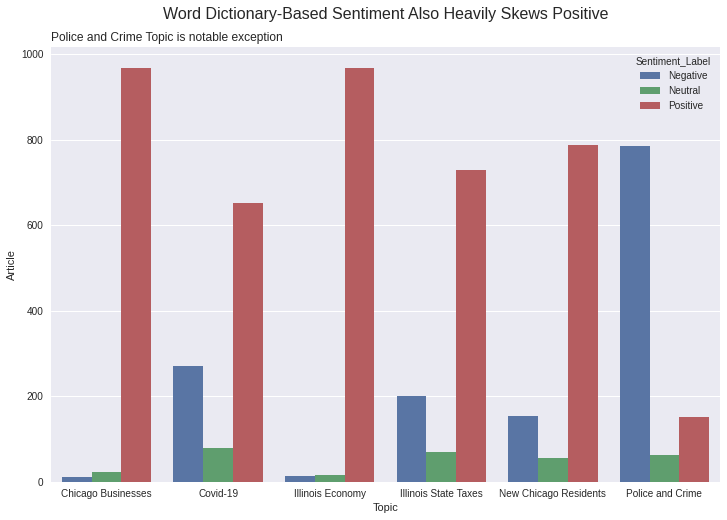

In [64]:
title_string = "Word Dictionary-Based Sentiment Also Heavily Skews Positive"
subtitle_string = "Police and Crime Topic is notable exception"

with plt.style.context('seaborn'):
    # plot titles, axes labels
    plt.figure(figsize=(12,8))
    plt.title(title_string, loc='center', y=1.05, fontsize=16)
    plt.title(subtitle_string, loc='left', fontsize=12)
    plt.xlabel("Topic")
    plt.ylabel("Number of Articles")

    # plot a bar chart of the article count per topic
    sns.barplot(x="Topic", y="Article", hue="Sentiment_Label", data=sentiment_counts)

    plt.show()

In [73]:
criteria = (articles_with_topics_sentiment['title'].str.contains('Pritzker', case=False)) | (articles_with_topics_sentiment['text_clean'].str.contains('Pritzker', case=False))
articles_with_topics_sentiment[criteria]['polarity'].median()

0.08599296536796537

In [81]:
criteria = (articles_with_topics_sentiment['text_clean'].str.contains('Lightfoot', case=False)) & (articles_with_topics_sentiment['Top_Topic'] == 'Police and Crime')
articles_with_topics_sentiment[criteria]['polarity'].median()

0.022467406624383367

In [82]:
all_sample_sentiments

,Article,Sentiment_Score,Topic,Sentiment_Label
0,LOUISVILLE State Representative Darren Bailey is encouraging people to consider applying for grants to support childcare centers who have been impacted by the recent coronavirus shutdowns. An additional 114 million in grants will be available for...,0.048276,Illinois State Taxes,Positive
1,"February 22, 2021 More details on Cuomos amended legal cannabis plan Illinois stark preequity landscape North Carolina poll more. The Cannabis Wire Daily newsletter is sent to CWire Plus subscribers every weekday morning at 7 a.m. Excerpts a...",0.000000,Illinois State Taxes,Neutral
2,"Woodstock4All Select Page CAPITOL RECAP: Black Caucus lays out antiracism agenda panel to probe Madigan ties to ComEd Illinois census update 4, 2020 3:37 pm Tags: Capitol News Illinois , The Woodstock Independent. By Capitol News Illinois. SPR...",0.006821,Illinois State Taxes,Positive
3,"on Tuesday savored her hardfought budget victory, even though her winning margin was the narrowest in decades and could spell trouble when it comes to making the tough decisions ahead.. The mayors plan to raise property taxes by 94 million, fol...",0.002268,Illinois State Taxes,Positive
4,Chicago teachers face work stoppage in COVID19 safety plan dispute By Syndicated Content 1h ago. By Brendan OBrien. CHICAGO Reuters Chicago teachers appeared headed on Monday for a strike or lockout over their latest dispute with the thirdlarg...,0.004202,Illinois State Taxes,Positive
...,...,...,...,...
995,"Published by: Peter Karaverdian 11222020 Hello Traders Around The World I hope all is well to you in these times. Lets get into it One of the best things we have no matter what the world throws at us, is the opportunity to sit down almost anywher...",0.030568,Chicago Businesses,Positive
996,"Job Description Sales AssociateStock Chicago, ILRainbow USA is recognized as one of the fastest growing junior, kids, plus, and petite, specialty apparel retail chains and has grown to over 1,000 retail stores We have multiple retail lines that ...",0.064655,Chicago Businesses,Positive
997,"CHICAGO, IL JLL Capital Markets announced today that Mark Stern has joined the firm as a Managing Director in its Chicago office. Mr. Stern will be an integral part of the growing Midwest multihousing team where he will focus on investment advis...",0.040000,Chicago Businesses,Positive
998,"University Position Title: Associate Director, BSAMAS Department of Accountancy. FUNCTION. To lead and coordinate the BSAMAS program, including but not limited to recruiting, admissions, advising, curriculum development, and registrationschedu...",0.019347,Chicago Businesses,Positive


In [86]:
criteria = (all_sample_sentiments['Article'].str.contains('Lori Lightfoot', case=False)) & (all_sample_sentiments['Topic']=='Police and Crime')

all_sample_sentiments[criteria]['Sentiment_Score'].min()

-0.06109324758842444

##### Sentence-Level Sentiment (Per Topic)

In [ ]:
tokenizer = SentenceTokenizer()

In [ ]:
# helper functions

def tokenize_articles(topic, sample_size=250, confidence_threshold= 0.65):

  # select sample of articles (from pool of relatively high topic confidence)
  relevant_articles = articles_with_topics.loc[((articles_with_topics['Top_Topic'] == topic) & (articles_with_topics['Top_Topic_Confidence'] > confidence_threshold)),
                                            ['title', 'text_clean', 'Top_Topic', 'Top_Topic_Confidence']].sample(sample_size, random_state=123)

  relevant_articles.reset_index(inplace=True, drop=True)

  

  # bring whole body of text to a single string, create TextBlob blob object
  article_text = relevant_articles.to_string(columns=['text_clean'], index=False, header=False)
  
  # tokenize whole string to list of sentences
  sentence_list = tokenizer.tokenize(article_text)
  print(f'Found {len(sentence_list)} sentences from a sample of {sample_size} articles with a minimum topic confidence of {confidence_threshold}.')

  return sentence_list


In [ ]:
def get_sentiment(topic, sentence_list):

  # from __future__ import division  

  sentiment_scores=[]

  for sentence in sentence_list:
      sentiment_score=0

      for p in list(punctuation):
          sentence = sentence.replace(p,'')
          words = sentence.split(' ')
      for word in words:
          if word in pos_words:
              sentiment_score=sentiment_score+1

          if word in neg_words:
              sentiment_score=sentiment_score-1

      sentiment_scores.append(sentiment_score/len(words))
      
  article_sentence_sentiments = zip(sentence_list, sentiment_scores)

  # Create a dataframe from the results
  column_names = ["Sentence", "Sentiment_Score"]
  sentiment_results = [sentence_list, sentiment_scores]
  results_dict = dict(zip(column_names, sentiment_results))
  all_sentences_df = pd.DataFrame.from_dict(results_dict, orient='columns')
  all_sentences_df = all_sentences_df[column_names]   # set specific column order

  # Create a list to store the sentiments
  sent_list = []

  # For each row in the column,
  for row in all_sentences_df['Sentiment_Score']:
      if row > 0:
          sent_list.append('Positive')
      elif row < 0:
          sent_list.append('Negative')
      else:
          sent_list.append('Neutral')

  # Create a column from the list
  all_sentences_df['Sentiment_Label'] = sent_list
  all_sentences_df['Topic'] = topic

  # return dataframe
  return all_sentences_df

##### Illinois

In [ ]:
# illinois government

illinois_sentences = tokenize_articles(topic="Illinois State Taxes", sample_size=500, confidence_threshold=0.70)

Found 11334 sentences from a sample of 500 articles with a minimum topic confidence of 0.7.


In [ ]:
%time illinois_sentiment = get_sentiment(topic="Illinois State Taxes", sentence_list=illinois_sentences)

CPU times: user 11min 59s, sys: 501 ms, total: 11min 59s
Wall time: 11min 58s


In [ ]:
illinois_sentiment.head(10)

,Sentence,Sentiment_Score,Sentiment_Label,Topic
0,...,-0.000061,Negative,Illinois State Taxes
1,"The program, which allows Chicago to intercept individuals state tax refunds, was the subject of a May investigation by The Chicago Reporter and Type Investigations ..",0.000000,Neutral,Illinois State Taxes
2,"In March, the Lightfoot administration announced it would temporarily suspend some of its debt collection efforts, along with the charging of late fees and interest.",0.040000,Positive,Illinois State Taxes
3,"These measures, the city announced , represent the first steps of the administrations efforts to help reduce the financial impact of COVID19 on city residents.",0.040000,Positive,Illinois State Taxes
4,Residents who owed the city fines and fees for nonpublic safety violations would be granted a temporary reprieve.,0.000000,Neutral,Illinois State Taxes
5,That reprieve ended on July 1 ..,0.000000,Neutral,Illinois State Taxes
6,"Since taking office, Lightfoot has led state reforms to end the practice of suspending driver licenses for failure to pay fines and fees for most nondriving related offenses, launched an amnesty program for city sticker debt, and passed other ref...",0.000000,Neutral,Illinois State Taxes
7,"As part of Lightfoots Forward Together COVID19 recovery plan, she has also promised more flexibility for small businesses particularly black and brownowned businesses when collecting fees until an effective treatment or vaccine is available..",0.000000,Neutral,Illinois State Taxes
8,"However, according to data from the Illinois comptrollers office obtained by The Chicago Reporter and Type Investigations, as of June 19, Chicago had intercepted 27 million from individuals 2020 state tax refunds due to people who overpaid on th...",0.000000,Neutral,Illinois State Taxes
9,These findings come as Chicagos finances are under significant strain.,0.000000,Neutral,Illinois State Taxes


In [ ]:
illinois_sentiment['Sentiment_Label'].value_counts()

Neutral     5191
Positive    4072
Negative    2071
Name: Sentiment_Label, dtype: int64

In [ ]:
illinois_sentiment[(illinois_sentiment['Sentiment_Label'] == 'Positive') & (illinois_sentiment['Sentiment_Score'] > 0.25)][['Sentence', 'Sentiment_Score', 'Sentiment_Label']].sort_values(by='Sentiment_Score', ascending=False)

,Sentence,Sentiment_Score,Sentiment_Label
4761,Thats fairness.,0.500000,Positive
10584,More will be necessary.,0.500000,Positive
10179,Make remote learning better.,0.500000,Positive
4737,"Madigan, courtesy.",0.500000,Positive
1170,Hes an incredibly smart guy.,0.400000,Positive
5304,Restoring the publics trust is of paramount importance.,0.375000,Positive
10023,Fighting for fairness.,0.333333,Positive
8967,All rights reserved.,0.333333,Positive
6419,All rights reserved.,0.333333,Positive
4876,Through interpretive dance..,0.333333,Positive


In [ ]:
illinois_sentiment[(illinois_sentiment['Sentiment_Label'] == 'Negative') & (illinois_sentiment['Sentiment_Score'] < -0.20)][['Sentence', 'Sentiment_Score', 'Sentiment_Label']].sort_values(by='Sentiment_Score', ascending=True)

,Sentence,Sentiment_Score,Sentiment_Label
5098,Attack corruption.,-0.500000,Negative
1245,Its daunting.,-0.500000,Negative
11291,Political corruption is the worst type of corruption.,-0.375000,Negative
8568,Application scoring concerns.,-0.333333,Negative
4407,E addressing economic insecurity and inequality.,-0.333333,Negative
2821,"Some states need little, if anything.",-0.333333,Negative
278,It was shameful.,-0.333333,Negative
1490,Others see the risk as overblown.,-0.333333,Negative
11099,Any claim to the contrary is unfounded..,-0.285714,Negative
1719,Its not fear mongering.,-0.250000,Negative


Neutral     5191
Positive    4072
Negative    2071
dtype: int64



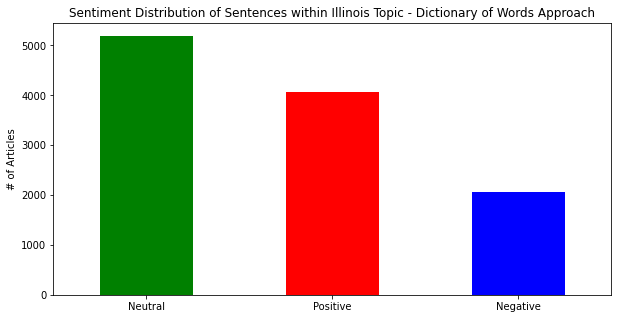

In [ ]:
# plot distibution of article sentiment
plt.figure().set_size_inches(10, 5)

CountSentiment = pd.value_counts(illinois_sentiment['Sentiment_Label'].values,
                                 sort=True)
print(CountSentiment)
print('')

# plot distibution of article sentiment
CountSentiment.plot(kind='bar', color=['g', 'r', 'b'],
                    title='Sentiment Distribution of Sentences within Illinois Topic - Dictionary of Words Approach')
plt.xticks(rotation=360)
plt.ylabel('# of Articles')
plt.show()

In [ ]:
illinois_sentiment.to_pickle(directory + 'illinois_taxes_sentiment.pkl')

##### Crime

In [ ]:
# crime

crime_sentences = tokenize_articles(topic="Police and Crime", sample_size=300, confidence_threshold=0.65)

Found 7202 sentences from a sample of 300 articles with a minimum topic confidence of 0.65.


In [ ]:
%time crime_sentiment = get_sentiment(topic="Police and Crime", sentence_list=crime_sentences)

CPU times: user 6min 40s, sys: 337 ms, total: 6min 41s
Wall time: 6min 40s


In [ ]:
crime_sentiment.to_pickle(directory + 'crime_sentiment.pkl')

In [ ]:
crime_sentiment['Sentiment_Label'].value_counts()

Neutral     3534
Negative    2422
Positive    1246
Name: Sentiment_Label, dtype: int64

In [ ]:
# positive sentences
crime_sentiment[(crime_sentiment['Sentiment_Label'] == 'Positive') & (crime_sentiment['Sentiment_Score'] > 0.25)][['Sentence', 'Sentiment_Score', 'Sentiment_Label']].sort_values(by='Sentiment_Score', ascending=False)

,Sentence,Sentiment_Score,Sentiment_Label
815,Thats pretty sophisticated.,0.666667,Positive
2445,Its okay.,0.500000,Positive
6175,Businesses will remain open.,0.500000,Positive
3248,"Yeah, sure..",0.500000,Positive
4027,The guardian angel characterization was more accurate..,0.428571,Positive
5432,All rights reserved.,0.333333,Positive
5293,Accept federal support.,0.333333,Positive
4982,All rights reserved.,0.333333,Positive
4773,We deserve better.,0.333333,Positive
4772,We demand better.,0.333333,Positive


In [ ]:
# negative sentences
crime_sentiment[(crime_sentiment['Sentiment_Label'] == 'Negative') & (crime_sentiment['Sentiment_Score'] < -0.20)][['Sentence', 'Sentiment_Score', 'Sentiment_Label']].sort_values(by='Sentiment_Score', ascending=True)

,Sentence,Sentiment_Score,Sentiment_Label
1188,"Its fragile, obviously.",-0.666667,Negative
4934,Carjacking murder.,-0.500000,Negative
5165,Very disheartening.,-0.500000,Negative
2421,My bad.,-0.500000,Negative
1746,Park conflict.,-0.500000,Negative
3598,And hes a dangerous idiot.,-0.400000,Negative
3408,Its a disappointment.,-0.333333,Negative
3401,It is unbearable.,-0.333333,Negative
2243,Stores hit hard.,-0.333333,Negative
1274,No more excuses.,-0.333333,Negative


##### Chicago Residents

In [ ]:
chicago_sentences = tokenize_articles(topic="New Chicago Residents", sample_size=300, confidence_threshold=0.65)

Found 12026 sentences from a sample of 300 articles with a minimum topic confidence of 0.65.


In [ ]:
%time chicago_sentiment = get_sentiment(topic="New Chicago Residents", sentence_list=chicago_sentences)

CPU times: user 7min 15s, sys: 409 ms, total: 7min 15s
Wall time: 7min 15s


In [ ]:
chicago_sentiment['Sentiment_Label'].value_counts()

Neutral     5687
Positive    4371
Negative    1968
Name: Sentiment_Label, dtype: int64

In [ ]:
# positive sentences
chicago_sentiment[(chicago_sentiment['Sentiment_Label'] == 'Positive') & (chicago_sentiment['Sentiment_Score'] > 0.25)][['Sentence', 'Sentiment_Score', 'Sentiment_Label']].sort_values(by='Sentiment_Score', ascending=False)

,Sentence,Sentiment_Score,Sentiment_Label
10675,"Pretty impressive, right.",0.666667,Positive
72,Losing free agency interest.,0.500000,Positive
2159,Its amazing.,0.500000,Positive
11699,Thats exciting.,0.500000,Positive
11267,listen live.,0.500000,Positive
...,...,...,...
4623,Jenkins: Thats so moving Thats so incredible and wonderful to hear.,0.272727,Positive
4105,This is still a project that I just love and love..,0.272727,Positive
10436,His personality was so beautiful and just lit up the room.,0.272727,Positive
2405,"The schedule sets up pretty well too, especially the first half.",0.272727,Positive


In [ ]:
# negative sentences
chicago_sentiment[(chicago_sentiment['Sentiment_Label'] == 'Negative') & (chicago_sentiment['Sentiment_Score'] < -0.25)][['Sentence', 'Sentiment_Score', 'Sentiment_Label']].sort_values(by='Sentiment_Score', ascending=False)

,Sentence,Sentiment_Score,Sentiment_Label
6817,Advertisement Nor has it felt less imminent.,-0.285714,Negative
4510,You hardly ever.,-0.333333,Negative
3247,I wasnt mad.,-0.333333,Negative
8889,"A fraught election year, a fastclimbing death toll, a nation in turmoil..",-0.333333,Negative
7527,"Up, then down.",-0.333333,Negative
7093,I miss fiction.,-0.333333,Negative
6937,It was dope.,-0.333333,Negative
5928,We were wrong.,-0.333333,Negative
5546,He was frustrated.,-0.333333,Negative
3885,Theyre really in a weird spot.,-0.333333,Negative


In [ ]:
chicago_sentiment.to_pickle(directory + 'chicago_residents_sentiment.pkl')

##### Chicago Business

In [ ]:
chicago_business_sentences = tokenize_articles(topic="Chicago Businesses", sample_size=300, confidence_threshold=0.65)

Found 12026 sentences from a sample of 300 articles with a minimum topic confidence of 0.65.


In [ ]:
%time chicago_sentiment = get_sentiment(topic="New Chicago Residents", sentence_list=chicago_sentences)

CPU times: user 7min 15s, sys: 409 ms, total: 7min 15s
Wall time: 7min 15s


In [ ]:
chicago_sentiment['Sentiment_Label'].value_counts()

Neutral     5687
Positive    4371
Negative    1968
Name: Sentiment_Label, dtype: int64

In [ ]:
# positive sentences
chicago_sentiment[(chicago_sentiment['Sentiment_Label'] == 'Positive') & (chicago_sentiment['Sentiment_Score'] > 0.25)][['Sentence', 'Sentiment_Score', 'Sentiment_Label']].sort_values(by='Sentiment_Score', ascending=False)

,Sentence,Sentiment_Score,Sentiment_Label
10675,"Pretty impressive, right.",0.666667,Positive
72,Losing free agency interest.,0.500000,Positive
2159,Its amazing.,0.500000,Positive
11699,Thats exciting.,0.500000,Positive
11267,listen live.,0.500000,Positive
...,...,...,...
4623,Jenkins: Thats so moving Thats so incredible and wonderful to hear.,0.272727,Positive
4105,This is still a project that I just love and love..,0.272727,Positive
10436,His personality was so beautiful and just lit up the room.,0.272727,Positive
2405,"The schedule sets up pretty well too, especially the first half.",0.272727,Positive


### Named-Entity Recognition (NER)

In [52]:
# NER packages
import nltk as nltk
import nltk.corpus
from nltk.text import Text

import spacy
from spacy import displacy

import spacy.cli
spacy.cli.download("en_core_web_md")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [53]:
spacy_model = spacy.load('en_core_web_md')

In [54]:
# create lists to store entities and labels from articles and titles
entities = []
labels = []

# define a helper function that uses SpaCey to perform NE recognition and stores the tagged entities and labels in corresponding lists
def spacy_ner(text):
    """
    Uses SpaCey to perform NE recognition on given text.
    Store the tagged entities and labels in corresponding lists.
    """
    doc = spacy_model(text)
    
    for ent in doc.ents:
        entities.append(str(ent))
        labels.append(ent.label_)

In [56]:
articles_with_topics_sentiment.head()

,title,rake_title_phrases,text_clean,rake_text_phrases,Top_Topic_Index,Top_Topic_Confidence,Top_Topic,polarity,subjectivity
0,All In Illinois,illinois,. Gov. Jay Fatso Pritzker called on all Illinois residents to be All in for Illinois and to sequester at home.. Now the rest is up to you. Our strongest weapon against COVID19 is you. For a little while longer we must all commit to staying home...,"elected governor last year .. obviously, illinois rising action told breitbart news, daily pandemic news conferences .. theres, 000 per year .. whats inappropriate, husbands newly extended coronavirus stayathome order, obese democratic illinois g...",4,0.412819,New Chicago Residents,0.084060,0.444079
1,CITY OF LASALLE: Restore Illinois,"restore illinois, lasalle, city","City of Lasalle issued the following announcement on May 8.. The governor just announced, Restore Illinois. This fivephased plan will reopen our state, guided by health metrics and with distinct business, education, and recreation activities cha...","southern illinois .. la salles region north central, based upon regional healthcare availability, 11 emergency medical services regions, northcentral illinois central illinois, alerts illinois valley times, lasalle weekly newsletter signup, state...",1,0.755099,Covid-19,0.099286,0.397202
2,Southern Illinois counties deal with funding shortfalls - SFGate,"southern illinois counties deal, funding shortfalls, sfgate","Southern Illinois counties deal with funding shortfalls Published 10:05 pm PDT, Saturday, May 9, 2020. BENTON, Ill. AP Franklin County, like Williamson County, is trying to find ways of mitigating lost tax revenue because of closures and reduce...","money could materialize .. newlyelected board member larry miller spoke, countys reserves .. board member ron ellis said, fellow board member brent gentry said, temporary employee whose sole job would, county board chairman randal crocker said, u...",6,0.908409,Illinois State Taxes,0.090010,0.369869
3,bankruptcy auction Chilicoti Illinois United States,bankruptcy auction chilicoti illinois united states,scarus compressus bankruptcy epfo member portal transfer claim in bankruptcy Morristown New Jersey United States bankruptcy auction usda loan requirements bankruptcy teddy riley examples and explanations bid bankruptcy Encinitas California North ...,education resources institute bankruptcy comex bankruptcy lehman brothers bankruptcy documentary youtube minnesota bankruptcy court filings bankruptcy estate lebanon virginia ryan buckrop bankruptcy white plains new york united states bankruptcy ...,3,0.583342,Consumer Economic Relief,0.116084,0.318998
4,Illinois Receives 1st Allotment of Remdesivir to Treat COVID-19 Patients: 90% Goes to Cook County,"illinois receives 1st allotment, treat covid, cook county, 19 patients, remdesivir, goes, 90","In this March 2020 photo provided by Gilead Sciences, rubber stoppers are placed onto filled vials of the investigational drug remdesivir at a Gilead manufacturing site in the United States. Gilead Sciences via AP. The only drug given emergency ...","illinois hospital chief medical officers .. ezike said, got 25 cases .. northwestern memorial hospital, deaths .. chicagos rush university medical center, despite low coronavirus infection totals relative, remdesivir illinois received saturday co...",1,0.812862,Covid-19,0.041898,0.322296


In [ ]:
# apply the NER function to the article titles
%time articles_with_topics_sentiment['title'].apply(spacy_ner)

CPU times: user 2h 22min 12s, sys: 1min 3s, total: 2h 23min 15s
Wall time: 2h 22min 47s


0        None
1        None
2        None
3        None
4        None
         ... 
80836    None
80837    None
80838    None
80839    None
80840    None
Name: title, Length: 80841, dtype: object

In [ ]:
entities_df.head()

,Entities,Labels
0,Illinois,GPE
1,LASALLE,GPE
2,Illinois,GPE
4,Chilicoti Illinois United States,ORG
5,Illinois Receives 1st Allotment of Remdesivir,ORG


In [ ]:
# create data frame for tagged entities
entities_df = pd.DataFrame({'Entities':entities, 'Labels':labels})

# select only organizations and then aggregate counts of unique entities 
entities_df = entities_df[(entities_df.Labels == 'ORG') | (entities_df.Labels == 'PERSON') | (entities_df.Labels == 'GPE')]
counts_df_spacy = entities_df.groupby('Entities').count()

# rename columns and sort by count in descending order
counts_df_spacy.rename(columns={"Labels": "Mentions"}, inplace=True)

counts_df_spacy.to_pickle(directory + 'title_ner_all.pkl')
counts_df_spacy.sort_values(by=['Mentions'], ascending=False).head(20)



,Mentions
Entities,
Chicago,26794
Illinois,18854
NYSE,4575
Illinois Tool Works Inc.,2170
ITW,1888
chicago,1652
Pritzker,1192
Illinois Municipal Retirement Fund,908
Trump,858


In [ ]:
# create data frame for tagged entities
entities_df = pd.DataFrame({'Entities':entities, 'Labels':labels})

# select only organizations and then aggregate counts of unique entities 
entities_df = entities_df[entities_df.Labels == 'PERSON']
counts_df_spacy = entities_df.groupby('Entities').count()

# rename columns and sort by count in descending order
counts_df_spacy.rename(columns={"Labels": "Mentions"}, inplace=True)
counts_df_spacy.to_pickle(directory + 'title_ner_people.pkl')

counts_df_spacy.sort_values(by=['Mentions'], ascending=False).head(20)

,Mentions
Entities,
Lightfoot,670
Pritzker,537
Lori Lightfoot,510
George Floyd,192
Trump,139
Aaron Sorkin,122
Madigan,110
Adam Toledo,107
Daywatch,106


In [ ]:
typez(counts_df_spacy)

pandas.core.series.Series

In [ ]:
counts_df_spacy.sort_values(by=['Mentions'], ascending=False).tail(20)

,Mentions
Entities,
HBCU,1
Guy-Maurice Amouzougan,1
HB3531,1
HB 3445,1
HAWAIIAN,1
HAVENTEES,1
HAV00030,1
HAT - Chicago Bulls,1
HARLEY DAVIDSON TRI,1


In [57]:
articles_sample = articles_with_topics_sentiment.sample(n=5000, random_state=123)

In [ ]:
# apply the NER function to the text column first
%time articles_sample['text_clean'].apply(spacy_ner)

In [ ]:
people_df = entities_df[(entities_df.Labels == 'PERSON')]
counts_df_spacy = people_df.groupby('Entities').count()

# rename columns and sort by count in descending order
counts_df_spacy.rename(columns={"Labels": "Mentions"}, inplace=True)
counts_df_spacy.sort_values(by=['Mentions'], ascending=False).head(20)

,Mentions
Entities,
Lightfoot,1266
Lori Lightfoot,969
Pritzker,735
George Floyd,543
J.B. Pritzker,538
Madigan,345
JB Pritzker,291
Donald Trump,289
Brown,256
